# S Forecast TensorFlow Examples

## Contents

This notebook demonstrates how to employ sforecast train/test fit (sliding/expanding window out-of-sample train/test) to make forecast fits and predictions with Tensorflow models The notebook demonstrates the mechanics of setting up and running the corresponding data and models. Mathematical, statistical, and interpretation discussions are out of scope of this notebook. 

Data and TensorFlow Models
   * M5 Walmart Sales Data, 7 Items
   * Univariate
   * Univariate and Exogenous Variables
   * Univariate and Categorical Embeddings
   * Multivariate + Exogenous + Endogenous + Categorical Embeddings, Multiple Output 
   * Multivarate LSTM + Exogenous + Categorical Embeddngs, Multiple Output

## Initialize Notebook

General Imports

In [1]:
import sforecast as sf
print(f'sforecast version = {sf.__version__}')
import pandas as pd
import numpy as np
import beautifulplots as bp
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from pandas.plotting import autocorrelation_plot
datapath = "../data"

sforecast version = 0.1.0


TensorFlow Imports

In [2]:
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, concatenate, Dropout
from keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

2023-01-13 11:45:49.435144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## M5 Sales data 7 items

M5 Sales 7 Items

In [3]:

df_m5sales7 = pd.read_csv("../data/m5_sales_7_items_events_cci_wide.csv", parse_dates = ["date"])
df_m5sales7 = df_m5sales7.set_index("date")
print("df_m5sales7")
display(df_m5sales7.tail())

# variable types
covars = [c for c in df_m5sales7.columns if "unit_sales_CA1_" in c]
catvars = [ "weekday", "event_name_1","event_name_2"]
exogvars = [ "year", "month" , "week",  "snap_CA",  "CCI_USA"]
Ncatvars = len(catvars)
Ncovars = len(covars)
Nexogvars = len(exogvars)

# dfXY ... covars + exogvars + catvars
cols = covars+catvars+exogvars
dfXY = df_m5sales7[cols].copy()

# label Encoding
le_catvars = [ "le_"+c for c in ["event_name_1","event_name_2"] ] # label encoded category columns ... weekday already encoded
print(le_catvars)
le = LabelEncoder()
dfXY[le_catvars] =dfXY[["event_name_1","event_name_2"] ].apply(le.fit_transform)
weekday_num = {"Sunday":0, "Monday":1, "Tuesday":2, "Wednesday":3, "Thursday":4, "Friday":5, "Saturday":6}
dfXY["le_weekday"] = dfXY["weekday"].apply( lambda x: weekday_num[x]) # create our own labels or label_encoder creates arbitrary number assignments
le_catvars = ["le_weekday"] + le_catvars # weekday is alread encoded ... add to le_catvars 
print(f'le_catvars = {le_catvars}')
print(f'N event_name_1 labels = {dfXY.groupby("event_name_1")["event_name_1"].count().index.size}')

# embedding dimensions
eindim = [dfXY[le_catvars].groupby(c)[c].count().index.size + 1 for c in le_catvars] # add 1 to the dim or err in TF
eoutdim = [np.rint(np.log2(x)).astype(int) for x in eindim]
print(f'eindim = {eindim}')
print(f'eoutdim = {eoutdim}')

# display dfXY
print(f'dfXY.shape = {dfXY.shape}')
print(f'\ndfXY.head = ')
display(dfXY.head())

df_m5sales7


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,sell_price_CA1_HOUSEHOLD_416,sell_price_CA1_FOODS_044,sell_price_CA1_FOODS_030,...,sell_price_CA1_FOODS_393,year,month,week,weekday,yearmonth,event_name_1,event_name_2,snap_CA,CCI_USA
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,3.88,2.5,1.48,...,3.56,2016,5,20,Wednesday,201605,NaN,NaN,0,100.7612
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,3.88,2.5,1.48,...,3.56,2016,5,20,Thursday,201605,NaN,NaN,0,100.7612
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,3.88,2.5,1.48,...,3.56,2016,5,20,Friday,201605,NaN,NaN,0,100.7612
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,3.88,2.5,1.48,...,3.56,2016,5,20,Saturday,201605,NaN,NaN,0,100.7612
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,3.88,2.5,1.48,...,3.56,2016,5,20,Sunday,201605,NaN,NaN,0,100.7612


['le_event_name_1', 'le_event_name_2']
le_catvars = ['le_weekday', 'le_event_name_1', 'le_event_name_2']
N event_name_1 labels = 30
eindim = [8, 32, 5]
eoutdim = [3, 5, 2]
dfXY.shape = (1206, 18)

dfXY.head = 


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,weekday,event_name_1,event_name_2,year,month,week,snap_CA,CCI_USA,le_event_name_1,le_event_name_2,le_weekday
date,,,,,,,,,,,,,,,,,,
2013-02-02,2.0,0.0,43.0,0.0,0.0,0.0,4.0,Saturday,NaN,NaN,2013,2,5,1,98.72734,30,3,6
2013-02-03,0.0,0.0,33.0,0.0,0.0,0.0,5.0,Sunday,SuperBowl,NaN,2013,2,5,1,98.72734,26,3,0
2013-02-04,1.0,1.0,5.0,0.0,0.0,0.0,1.0,Monday,NaN,NaN,2013,2,6,1,98.72734,30,3,1
2013-02-05,0.0,1.0,14.0,0.0,0.0,0.0,2.0,Tuesday,NaN,NaN,2013,2,6,1,98.72734,30,3,2
2013-02-06,0.0,1.0,11.0,0.0,0.0,0.0,2.0,Wednesday,NaN,NaN,2013,2,6,1,98.72734,30,3,3


## Univariate

Univariate Data

In [12]:
# y forecast variable
y = ["unit_sales_CA1_FOODS_030"]

# univariate data
print("dfXYtf univariate")
dfXYtf = dfXY[y] 
display(dfXYtf.tail())

dfXYtf univariate


,unit_sales_CA1_FOODS_030
date,
2016-05-18,7.0
2016-05-19,11.0
2016-05-20,9.0
2016-05-21,9.0
2016-05-22,8.0


TF Model - Dense Network, Univariate

In [13]:
# TensorFlow model with 3 hidden layers

Nlags=5
inputs = Input((Nlags,))
h1 = Dense(Nlags, activation='relu')(inputs)
h2 = Dense(20, activation='relu')(h1)
h3 = Dense(10, activation='relu')(h2)
output = Dense(1)(h3) # linear output
model_tf_dense = Model(inputs=inputs, outputs=output)

# define optimizer and compile
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense.compile(loss='mse', optimizer=optimizer)
print(model_tf_dense.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_8 (Dense)             (None, 5)                 30        
                                                                 
 dense_9 (Dense)             (None, 20)                120       
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None


TF forecast Univariate

In [14]:
# display data
print("dfXYtf")
display(dfXYtf.tail())

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model

# Forecast - fit
Ntest=10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None)
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 100,
    "batch_size":100
    }

sfuvtf = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense, tf_parameters=tf_params)

df_pred_uv = sfuvtf.fit(dfXYtf)

print(f'\nmetrics = {sfuvtf.metrics}')
dfXY_pred_uvtf = dfXYtf.join(df_pred_uv)
display(dfXY_pred_uvtf.tail())


dfXYtf


,unit_sales_CA1_FOODS_030
date,
2016-05-18,7.0
2016-05-19,11.0
2016-05-20,9.0
2016-05-21,9.0
2016-05-22,8.0


1/1 [==============================] - 0s 19ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 1.9239375447713913, 'MAE': 1.380906343460083}}


,unit_sales_CA1_FOODS_030,unit_sales_CA1_FOODS_030_train,unit_sales_CA1_FOODS_030_test,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_FOODS_030_pred_error,unit_sales_CA1_FOODS_030_pred_lower,unit_sales_CA1_FOODS_030_pred_upper
date,,,,,,,
2016-05-18,7.0,NaN,7.0,7.314797,0.314797,3.605901,8.211917
2016-05-19,11.0,NaN,11.0,7.090667,-3.909333,3.381771,7.987787
2016-05-20,9.0,NaN,9.0,9.203948,0.203948,5.495052,10.101068
2016-05-21,9.0,NaN,9.0,8.553405,-0.446595,4.844509,9.450525
2016-05-22,8.0,NaN,8.0,8.767711,0.767711,5.058815,9.664831


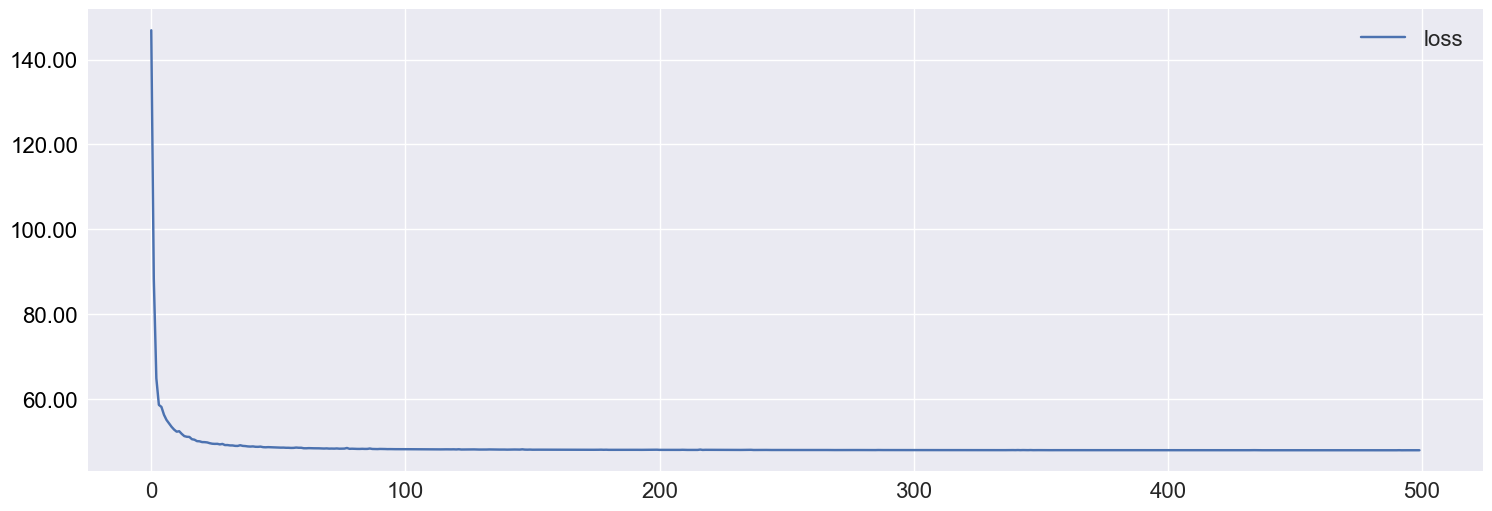

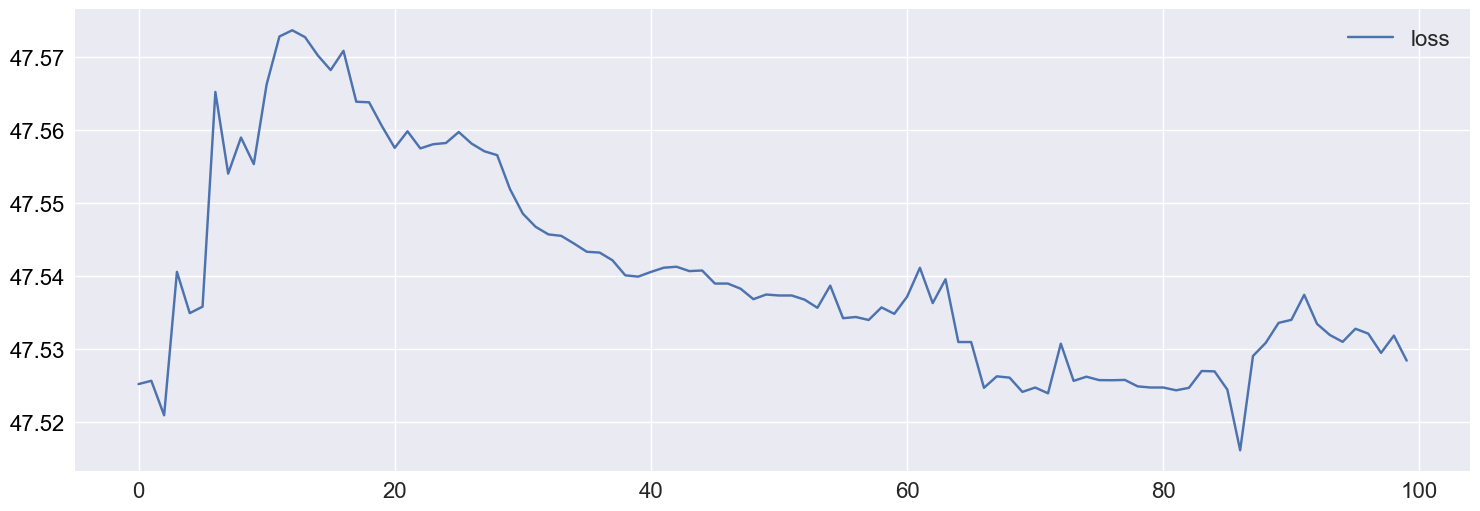

In [15]:
df_loss_i = pd.DataFrame(data = { "epoch": range(len(sfuvtf.history_i.history["loss"])), 
                                "loss":sfuvtf.history_i.history["loss"] })
bp.lineplot(df_loss_i, x ="epoch", y = "loss", figsize=(18,6) )

df_loss_t = pd.DataFrame(data = { "epoch": range(len(sfuvtf.history_t.history["loss"])), 
                                "loss":sfuvtf.history_t.history["loss"] })
bp.lineplot(df_loss_t, x ="epoch", y = "loss", figsize=(18,6) )

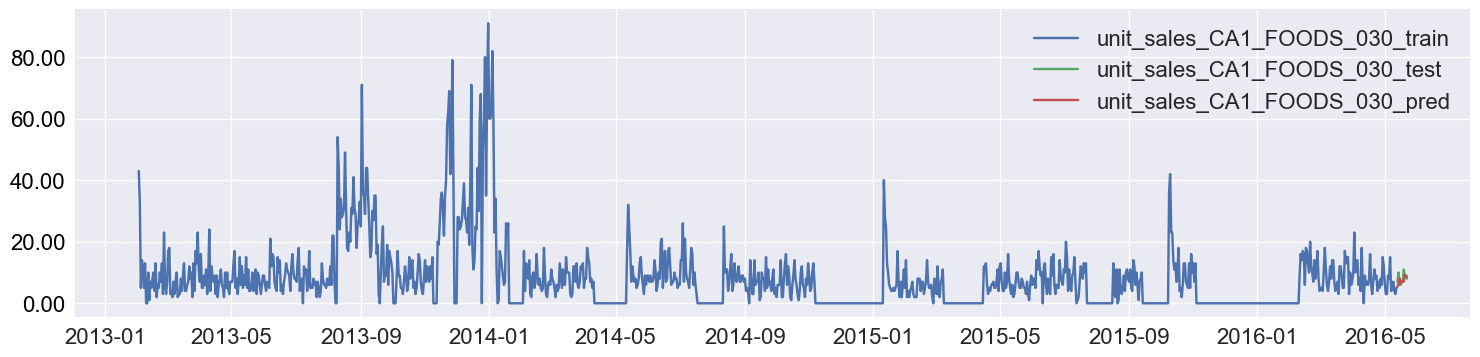

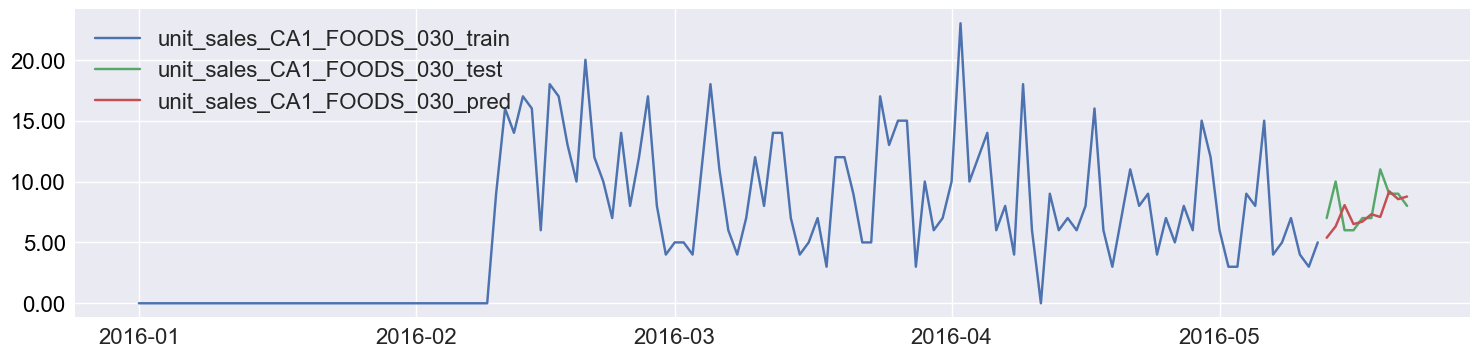

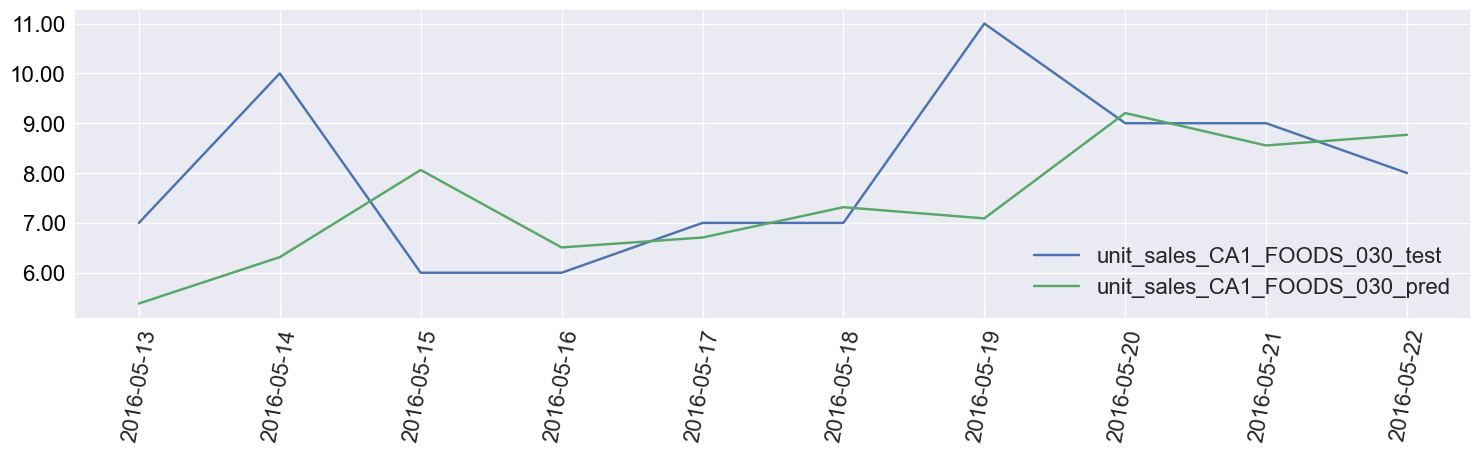

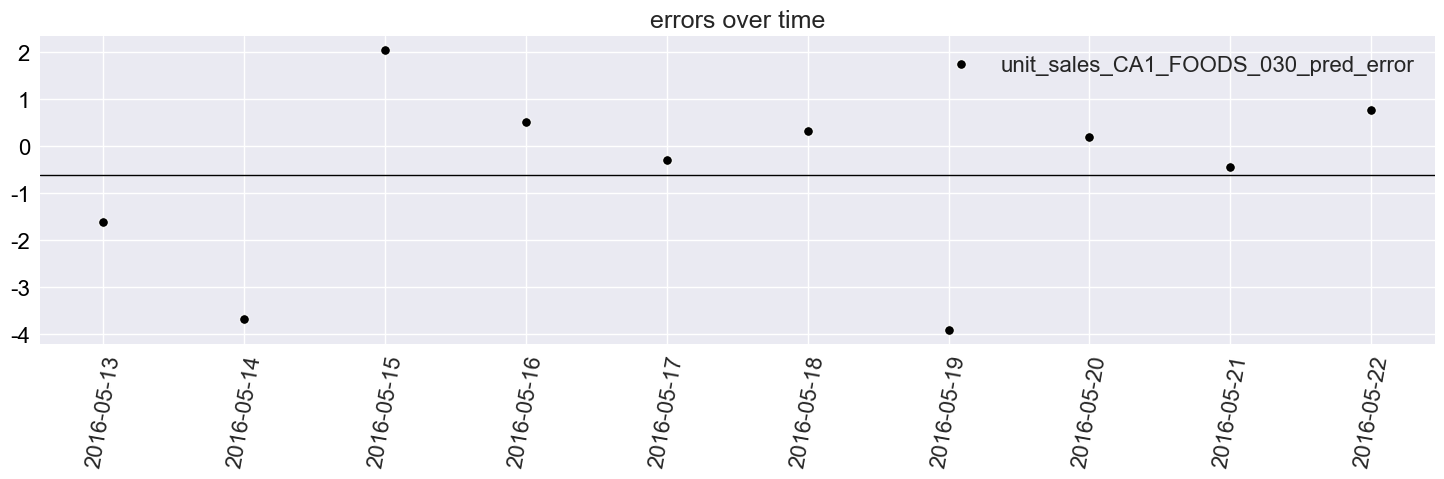

In [16]:
y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

df = dfXY_pred_uvtf.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

error_avg =df[error].mean()

bp.lineplot(df, x="date", y=[ytrain, ytest , ypred], figsize=(18,4))

d=datetime(2016,1,1)
bp.lineplot(df[df["date"]>=d], x="date", y=[ytrain, ytest , ypred], figsize=(18,4))

bp.lineplot(df.tail(30), x="date", y=[ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

bp.lineplot(df.tail(30), x="date", y=error,  h_line = [error_avg], 
            y_axis_format=".0f",linestyle="None", marker="o", color="k", 
            title = "errors over time", x_tick_rotation=80,  figsize=(18,4))

**Predict TF Univariate**

In [17]:
ts_period = pd.DateOffset(days=1)
#dfexogs=pd.DataFrame(data = {"dayofweek":[2,3,4,5,6]})
df_pred=sfuvtf.predict(Nperiods=3, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 24ms/step


,unit_sales_CA1_FOODS_030_pred
2016-05-23,8.561462
2016-05-24,8.727022
2016-05-25,8.697215


## Univariate with Exogenous

data with exogenous variables

**Exogenous Variables**

These variables are not dependent on the target (independent variable) and are ususally some form of external varialbe. For example, they could represent the weather, such as temperature or rain, or economic data, such as consumer confience index.

The exogenous variables are included in the input dataframe to the fit operation. An exogenous variables dataframe, one row per predict period is input to the predict operation.

Below is trivial example of exogenous variables, the month number is included as an exogenous variable input. df_airp has two variables the target variable and y = Passengers, and exogenous variable month_no

In [76]:
y = ["unit_sales_CA1_FOODS_030"]
dfXYtf = dfXY[ y + exogvars].copy()
print(exogvars)
print(dfXYtf.shape)
display(dfXYtf.tail(5))

['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 6)


,unit_sales_CA1_FOODS_030,year,month,week,snap_CA,CCI_USA
date,,,,,,
2016-05-18,7.0,2016,5,20,0,100.7612
2016-05-19,11.0,2016,5,20,0,100.7612
2016-05-20,9.0,2016,5,20,0,100.7612
2016-05-21,9.0,2016,5,20,0,100.7612
2016-05-22,8.0,2016,5,20,0,100.7612


TensorFlow Model

In [32]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Ndense = Nlags + Nexogvars #lagged covars (does not include unlagged covars) + exogvars
Nembout = sum(eoutdim)
Nout = 1

print(f'Ndense = {Ndense}')
print(f'Nout = {Nout}')

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
cont_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(cont_inputs)

# dense reduction layers
Nh1c = Ndense 
h1c = Dense(Nh1c, activation='relu')(h1d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_dense = Model(inputs=cont_inputs, outputs=output)

# define optimizer and compile ...
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense.compile(loss='mse', optimizer=optimizer)

print(model_tf_dense.summary())

Ndense = 10
Nout = 1
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_34 (Dense)            (None, 10)                110       
                                                                 
 dense_35 (Dense)            (None, 10)                110       
                                                                 
 dropout_17 (Dropout)        (None, 10)                0         
                                                                 
 dense_36 (Dense)            (None, 5)                 55        
                                                                 
 dropout_18 (Dropout)        (None, 5)                 0         
                                                                 
 dense_37 (Dense)            (None, 1)

Fit

In [40]:
# display data
print("dfXYtf")
display(dfXYtf.tail())

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model

# Forecast - fit
Ntest=10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "exogvars":exogvars,
    "minmax" :(0,None)
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 100,
    "batch_size":100
    }

sfuvexogtf = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense, tf_parameters=tf_params)

df_pred_uvexog = sfuvexogtf.fit(dfXYtf)

print(f'\nmetrics = {sfuvexogtf.metrics}')
dfXY_pred_uvexogtf = dfXYtf.join(df_pred_uvexog)
display(dfXY_pred_uvexogtf.tail())


dfXYtf


,unit_sales_CA1_FOODS_030,year,month,week,snap_CA,CCI_USA
date,,,,,,
2016-05-18,7.0,2016,5,20,0,100.7612
2016-05-19,11.0,2016,5,20,0,100.7612
2016-05-20,9.0,2016,5,20,0,100.7612
2016-05-21,9.0,2016,5,20,0,100.7612
2016-05-22,8.0,2016,5,20,0,100.7612


1/1 [==============================] - 0s 20ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 2.54411154491045, 'MAE': 1.992525577545166}}


,unit_sales_CA1_FOODS_030,year,month,week,snap_CA,CCI_USA,unit_sales_CA1_FOODS_030_train,unit_sales_CA1_FOODS_030_test,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_FOODS_030_pred_error,unit_sales_CA1_FOODS_030_pred_lower,unit_sales_CA1_FOODS_030_pred_upper
date,,,,,,,,,,,,
2016-05-18,7.0,2016,5,20,0,100.7612,NaN,7.0,6.028453,-0.971547,1.309231,5.779716
2016-05-19,11.0,2016,5,20,0,100.7612,NaN,11.0,5.970777,-5.029223,1.251554,5.722039
2016-05-20,9.0,2016,5,20,0,100.7612,NaN,9.0,6.904712,-2.095288,2.185489,6.655974
2016-05-21,9.0,2016,5,20,0,100.7612,NaN,9.0,6.844165,-2.155835,2.124943,6.595428
2016-05-22,8.0,2016,5,20,0,100.7612,NaN,8.0,6.966345,-1.033655,2.247123,6.717608


Plot

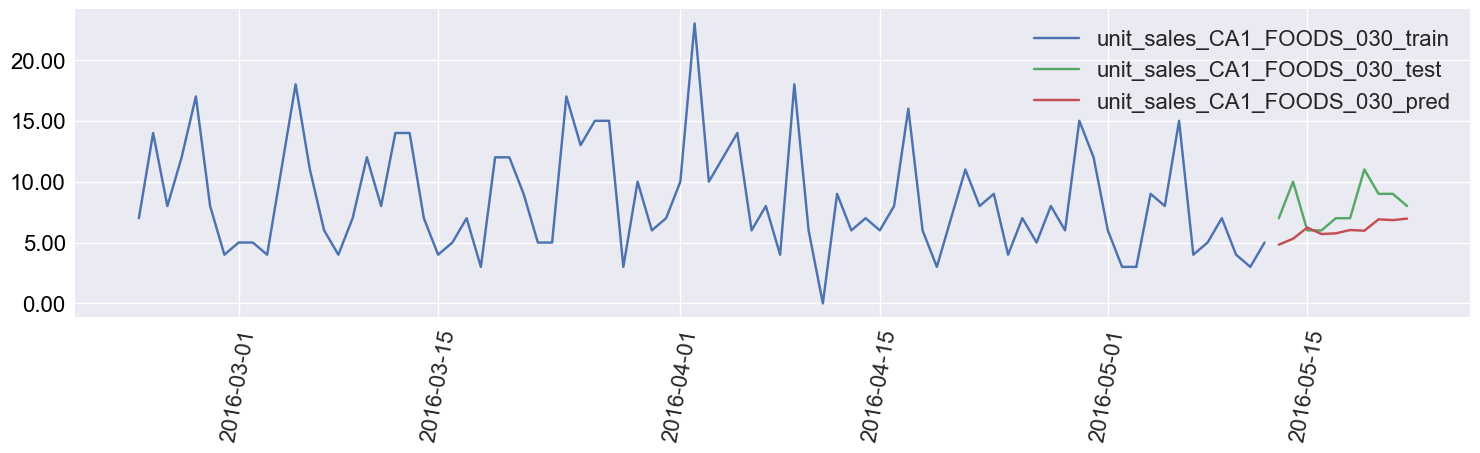

In [44]:
y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

df = dfXY_pred_uvexogtf.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

bp.lineplot(df.tail(90), x="date", y=[ytrain, ytest, ypred], figsize=(18,4),  x_tick_rotation=80)


Predict

In [46]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

df_pred=sfuvexogtf.predict(Nperiods=5,dfexogs = dfexogs, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 27ms/step


,unit_sales_CA1_FOODS_030_pred
2016-05-23,6.849082
2016-05-24,6.481734
2016-05-25,6.123740
2016-05-26,5.845281
2016-05-27,5.590785


## Univariate + Categorical Variables

data

In [48]:
# y forecast variable
y = ["unit_sales_CA1_FOODS_030"]
dfXYtf = dfXY[y+le_catvars]
display(dfXYtf.tail(10))

,unit_sales_CA1_FOODS_030,le_weekday,le_event_name_1,le_event_name_2
date,,,,
2016-05-13,7.0,5,30,3
2016-05-14,10.0,6,30,3
2016-05-15,6.0,0,30,3
2016-05-16,6.0,1,30,3
2016-05-17,7.0,2,30,3
2016-05-18,7.0,3,30,3
2016-05-19,11.0,4,30,3
2016-05-20,9.0,5,30,3
2016-05-21,9.0,6,30,3


TF Model with Univariate + Categorical  
Dense Network (Xlags = univariate lags) + Embeddings (Categorical Variables)

In [52]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables)
Nlags = 5
Ndense = Nlags  # N continous/dense variables, in this case covars is 1 (univarate)
Nembout = sum(eoutdim)

print("Nlags =", Nlags)
print("Ndense =", Nlags)
print("Nembout =", Nembout)

# Dense Network, 2 hidden layers, continuous variables ...lags
cont_inputs = Input((Ndense,))
h1c = Dense(Ndense, activation='relu')(cont_inputs)

# embeddings, cat vars

cat_inputs_list = [ Input((1,)) for c in range(Ncatvars) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1c]+emb_flat_list)

# dense reduction layers
Nh1_comb = Ndense + Nembout  # 
h1_comb = Dense(Nh1_comb, activation='relu')(combined)
Nh2_comb = np.rint(Nh1_comb/2).astype(int)
h2_comb = Dense(Nh2_comb, activation='relu')(h1_comb)

# output
output = Dense(1)(h2_comb)  # linear activation ... linear combination 

# build model
model_tf_dense_emb = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile ...
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)
print(model_tf_dense_emb.summary())

Nlags = 5
Ndense = 5
Nembout = 10
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 5)]          0           []                               
                                                         

Fit

In [53]:

# display data
print("dfXYtf")
display(dfXYtf.tail(5))

# define optimizer and compile ...
# re-compile every time before running to ensure initial training is really the first
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)

# Forcast Fit

Ntest = 10
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "catvars":le_catvars 
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sftfuvc = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense_emb, tf_parameters=tf_params)

df_pred_ccm5 = sftfuvc.fit(dfXYtf)

print(f'\nmetrics = {sftfuvc.metrics}')
dfXY_pred_ccm5 = dfXY.join(df_pred_ccm5)
display(dfXY_pred_ccm5.tail())


dfXYtf


,unit_sales_CA1_FOODS_030,le_weekday,le_event_name_1,le_event_name_2
date,,,,
2016-05-18,7.0,3,30,3
2016-05-19,11.0,4,30,3
2016-05-20,9.0,5,30,3
2016-05-21,9.0,6,30,3
2016-05-22,8.0,0,30,3


1/1 [==============================] - 0s 24ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 2.039456496240996, 'MAE': 1.6761991024017333}}


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,weekday,event_name_1,event_name_2,...,CCI_USA,le_event_name_1,le_event_name_2,le_weekday,unit_sales_CA1_FOODS_030_train,unit_sales_CA1_FOODS_030_test,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_FOODS_030_pred_error,unit_sales_CA1_FOODS_030_pred_lower,unit_sales_CA1_FOODS_030_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,Wednesday,NaN,NaN,...,100.7612,30,3,3,NaN,7.0,6.044095,-0.955905,4.226142,7.626092
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,Thursday,NaN,NaN,...,100.7612,30,3,4,NaN,11.0,6.184527,-4.815473,4.366574,7.766524
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,Friday,NaN,NaN,...,100.7612,30,3,5,NaN,9.0,10.044666,1.044666,8.226713,11.626663
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,Saturday,NaN,NaN,...,100.7612,30,3,6,NaN,9.0,11.706332,2.706332,9.888379,13.288329
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,Sunday,NaN,NaN,...,100.7612,30,3,0,NaN,8.0,8.809814,0.809814,6.991861,10.391811


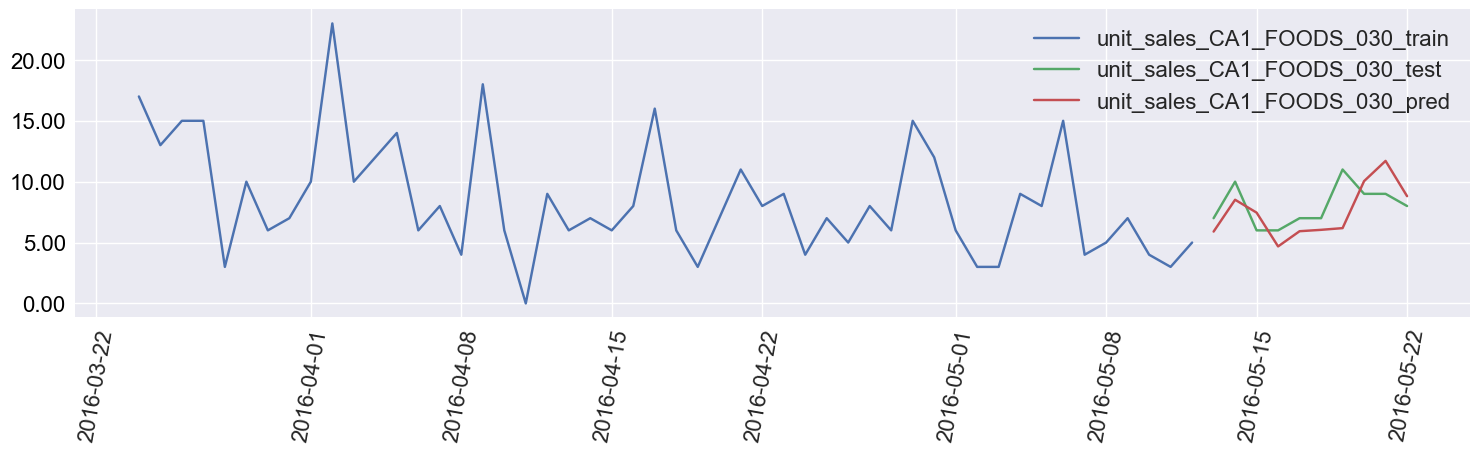

In [56]:
y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"

df = dfXY_pred_ccm5.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

Predict

In [57]:
ts_period = pd.DateOffset(days=1)
dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sftfuvc.predict(Nperiods=5, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 27ms/step


,unit_sales_CA1_FOODS_030_pred
2016-05-23,5.996592
2016-05-24,6.830101
2016-05-25,6.043812
2016-05-26,6.022969
2016-05-27,7.782898


## Multivariate with Exogenous, and Categorical Variables

data

In [64]:
dfXYtf = dfXY[covars+exogvars+le_catvars].copy()
print(catvars)
print(exogvars)
print(dfXYtf.shape)
display(dfXYtf.tail(5))

['weekday', 'event_name_1', 'event_name_2']
['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3


TF Model - Dense (exog + covariate lags) + Embeddings (categorical variables) + Nout = len(covars)

In [65]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Ndense = Nlags * Ncovars + Nexogvars #lagged covars (does not include unlagged covars) + exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
print(f'Nout = {Nout}')

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
cont_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(cont_inputs)

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_dense_emb = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile ...
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)

print(model_tf_dense_emb.summary())

Ndense = 40
Nemb = 3
Nout = 7
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 40)]         0           []                               
                                                             

Forecast Fit Multivariate with Exogenous and Catvars

In [66]:
# display data
# display data
print("dfXYtf")
display(dfXYtf.tail(5))

y = ["unit_sales_CA1_FOODS_030", "unit_sales_CA1_HOUSEHOLD_416" ,  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model

# forecast fit
Ntest = 10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "catvars":le_catvars

    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sfmvembmo = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense_emb, tf_parameters=tf_params)

df_pred_mvcatmo = sfmvembmo.fit(dfXYtf)

print(f'\nmetrics = {sfmvembmo.metrics}')
dfXY_pred_mvcatmo = dfXYtf.join(df_pred_mvcatmo)
display(dfXY_pred_mvcatmo.tail())

dfXYtf


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3



y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_HOUSEHOLD_416', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 25ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 3.4107022675953482, 'MAE': 2.9040186166763307}, 'unit_sales_CA1_HOUSEHOLD_416_pred': {'RMSE': 1.3074823432354468, 'MAE': 1.1401813983917237}, 'unit_sales_CA1_FOODS_393_pred': {'RMSE': 4.188019410260901, 'MAE': 3.267935872077942}}


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,...,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_HOUSEHOLD_416_pred_error,unit_sales_CA1_HOUSEHOLD_416_pred_lower,unit_sales_CA1_HOUSEHOLD_416_pred_upper,unit_sales_CA1_FOODS_393_train,unit_sales_CA1_FOODS_393_test,unit_sales_CA1_FOODS_393_pred,unit_sales_CA1_FOODS_393_pred_error,unit_sales_CA1_FOODS_393_pred_lower,unit_sales_CA1_FOODS_393_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,...,1.381046,-0.618954,0.0,2.780917,NaN,5.0,3.970874,-1.029126,0.0,7.050132
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,...,1.351592,-0.648408,0.0,2.751463,NaN,8.0,4.736276,-3.263724,0.0,7.815535
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,...,1.447492,0.447492,0.0,2.847363,NaN,5.0,5.940054,0.940054,0.0,9.019313
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,...,1.420553,1.420553,0.0,2.820424,NaN,5.0,5.988474,0.988474,0.0,9.067733
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,...,1.361148,-1.638852,0.0,2.761020,NaN,15.0,5.931062,-9.068938,0.0,9.010321


Plot

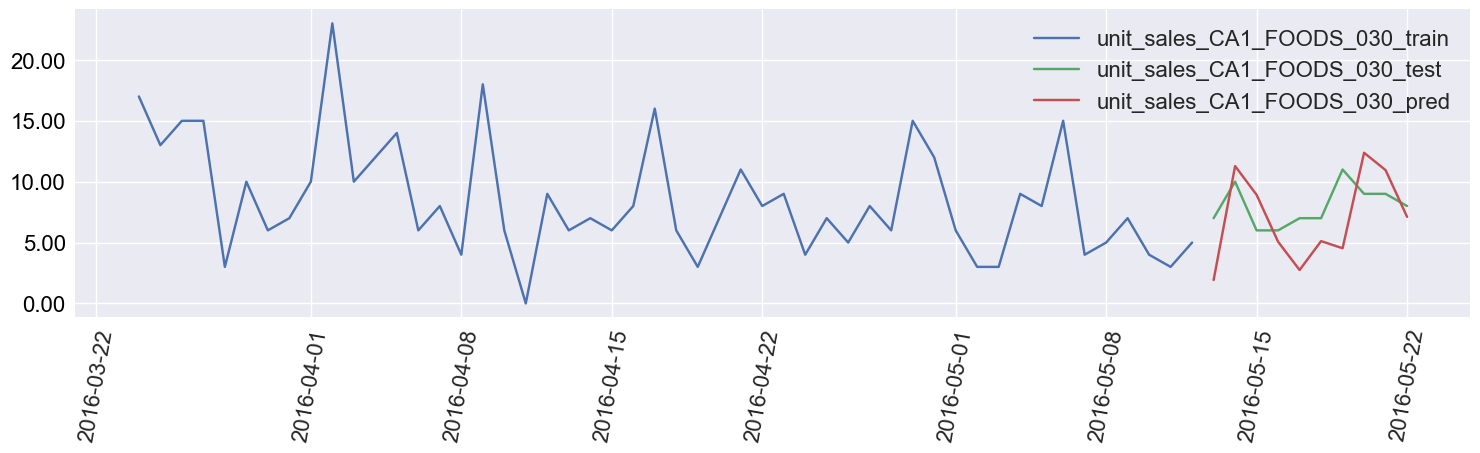

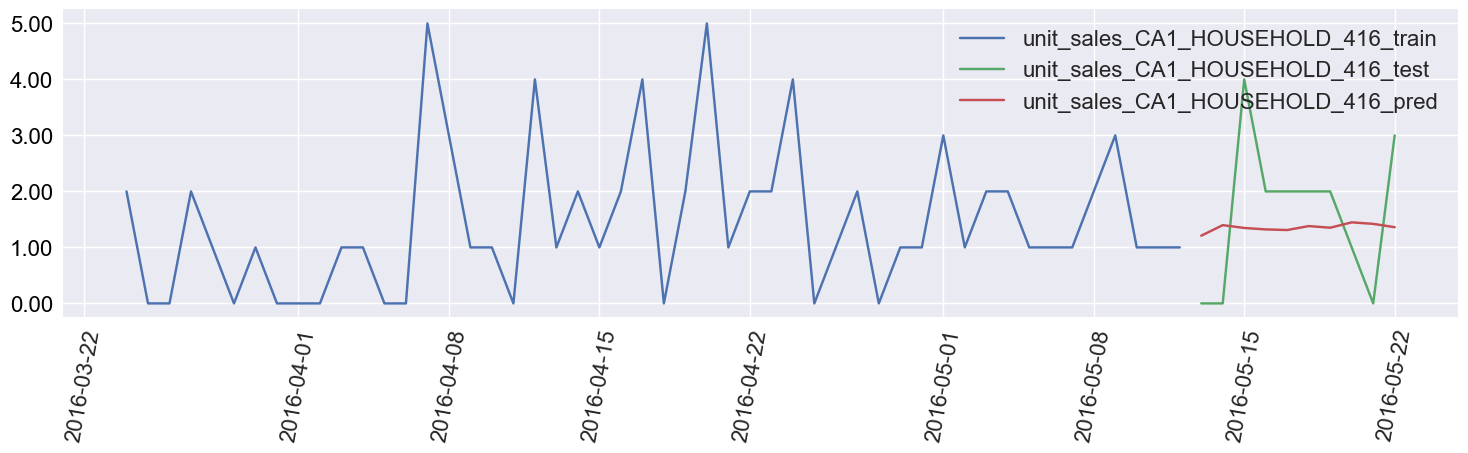

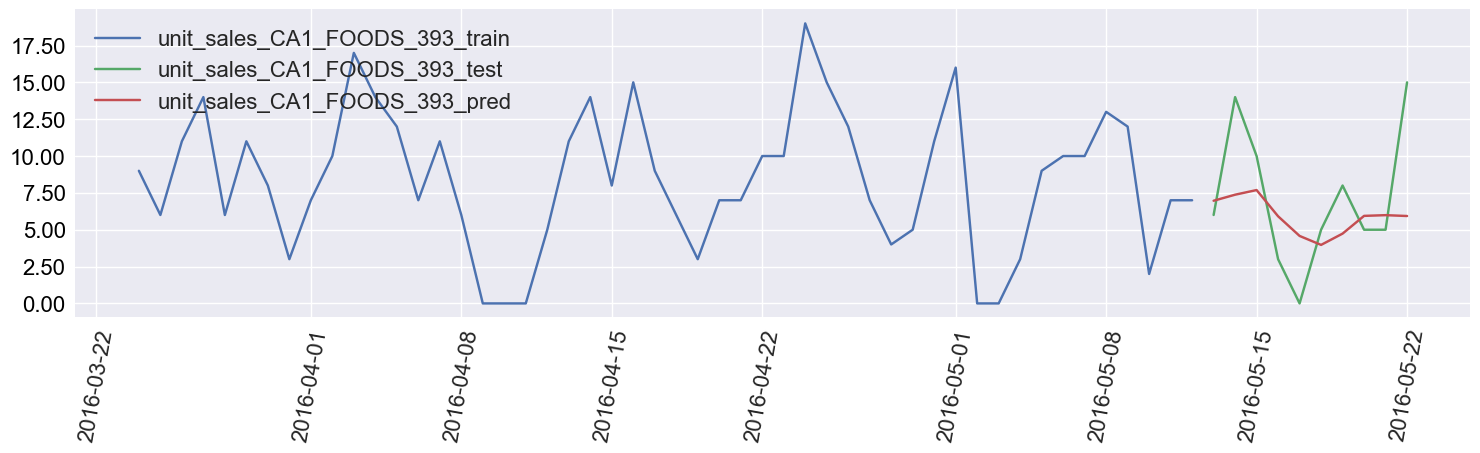

In [69]:


df = dfXY_pred_mvcatmo.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_HOUSEHOLD_416"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)


y = "unit_sales_CA1_FOODS_393"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"


bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)


Predict multivariate with exogenous and categorical

In [70]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sfmvembmo.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 27ms/step


,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_FOODS_393_pred
2016-05-23,5.279810,1.319376,6.355587
2016-05-24,7.089170,1.375724,5.468899
2016-05-25,3.878172,1.334896,5.190464


## Multivariate with Exogenous, Endogenous, and Categorical

data

In [13]:
# same data as previous multivariate example

dfXYtf = dfXY[covars+exogvars+le_catvars].copy()
endogs =  ['unit_sales_CA1_FOODS_030_m1_ravg3', 'unit_sales_CA1_HOUSEHOLD_416_m1_ravg3', 
           'unit_sales_CA1_FOODS_393_m1_ravg3', 'unit_sales_CA1_FOODS_030_m1_rstd3', 
           'unit_sales_CA1_HOUSEHOLD_416_m1_rstd3', 'unit_sales_CA1_FOODS_393_m1_rstd3']
print(endogs)
print(catvars)
print(exogvars)
print(dfXYtf.shape)
display(dfXYtf.tail(10))

['unit_sales_CA1_FOODS_030_m1_ravg3', 'unit_sales_CA1_HOUSEHOLD_416_m1_ravg3', 'unit_sales_CA1_FOODS_393_m1_ravg3', 'unit_sales_CA1_FOODS_030_m1_rstd3', 'unit_sales_CA1_HOUSEHOLD_416_m1_rstd3', 'unit_sales_CA1_FOODS_393_m1_rstd3']
['weekday', 'event_name_1', 'event_name_2']
['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-13,0.0,2.0,7.0,2.0,1.0,0.0,6.0,2016,5,19,0,100.7612,5,30,3
2016-05-14,0.0,1.0,10.0,0.0,6.0,1.0,14.0,2016,5,19,0,100.7612,6,30,3
2016-05-15,4.0,1.0,6.0,0.0,3.0,1.0,10.0,2016,5,19,0,100.7612,0,30,3
2016-05-16,2.0,2.0,6.0,1.0,0.0,1.0,3.0,2016,5,20,0,100.7612,1,30,3
2016-05-17,2.0,4.0,7.0,1.0,1.0,0.0,0.0,2016,5,20,0,100.7612,2,30,3
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3


**Endogenous Variables**  
  
Endogenous variables are somehow dependent on the target (independent) variable(s). Often, these are variables derived from past targget variables. 

Sforecast employs SKlearn transform to derive variables based on past observations. A "Derived Variable Transform" is provided as input to the sforecast model. Based on this transform, endogenous (i.e., derived variables) are derived prior to each forecast.
  
In summary, the derived variable transform works as follws. Before each prediction, take the output from the previous prediction (i.e., recursive forecast) and update the transform memory. Then create a new set of derived variables. 

In this case, the below transform employs a rolling function (window = Nr past rows) to create mean and standard deviation variables. Since derived variables transform includes rolling window functions then enough past dataframe rows are saved for generation of the derived variables.

After each new prediction, a new row is appended to the dataframe and the most recent Nr rows are saved for generation of the next set of derived variables.

In [5]:
# deirvied variables transform

# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes_tf(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
        
        v1 = "unit_sales_CA1_FOODS_030"
        v2 = "unit_sales_CA1_HOUSEHOLD_416"
        v3 = "unit_sales_CA1_FOODS_393"
        self.vlist = [v1, v2, v3]
        f1 = lambda x:x+"_m1_ravg"+str(Nr)
        f2 = lambda x:x+"_m1_rstd"+str(Nr)
        self.new_attributes = [f(v) for f in (f1, f2 )for v in self.vlist]
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
                # variables
        
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        for v in self.vlist:
            v_ravg = v+"_m1_ravg"+str(Nr)
            v_rstd =  v+"_m1_rstd"+str(Nr)
            v_m1 = v+"_m1"
            dfnew[v_ravg] = dfnew[v_m1].rolling(window=Nr).mean()
            dfnew[v_rstd] = dfnew[v_m1].rolling(window=Nr).std()

        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows that should be desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return self.new_attributes
 
cols = ["unit_sales_CA1_FOODS_030" , "unit_sales_CA1_HOUSEHOLD_416" , "unit_sales_CA1_FOODS_393"]        
dfXY_m1 = dfXYtf[cols].copy()


# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes_tf().get_Nclip()
print("Nclip =",Nclip)
drived_var_transform = derived_attributes_tf()
dfXY_m1[["unit_sales_CA1_FOODS_030_m1" , "unit_sales_CA1_HOUSEHOLD_416_m1" , "unit_sales_CA1_FOODS_393_m1" ]] = dfXY_m1[["unit_sales_CA1_FOODS_030" , "unit_sales_CA1_HOUSEHOLD_416" , "unit_sales_CA1_FOODS_393"]].shift(1)
dftest = drived_var_transform.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest.tail(5))

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

new_attributes = drived_var_transform.get_derived_attribute_names()
print(f'\nnew_attribute_names = {new_attributes}')

Nclip = 3
dataframe, dftest, with derived variables


,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_393,unit_sales_CA1_FOODS_030_m1,unit_sales_CA1_HOUSEHOLD_416_m1,unit_sales_CA1_FOODS_393_m1,unit_sales_CA1_FOODS_030_m1_ravg3,unit_sales_CA1_FOODS_030_m1_rstd3,unit_sales_CA1_HOUSEHOLD_416_m1_ravg3,unit_sales_CA1_HOUSEHOLD_416_m1_rstd3,unit_sales_CA1_FOODS_393_m1_ravg3,unit_sales_CA1_FOODS_393_m1_rstd3
date,,,,,,,,,,,,
2016-05-18,7.0,2.0,5.0,7.0,2.0,0.0,6.333333,0.577350,2.666667,1.154701,4.333333,5.131601
2016-05-19,11.0,2.0,8.0,7.0,2.0,5.0,6.666667,0.577350,2.000000,0.000000,2.666667,2.516611
2016-05-20,9.0,1.0,5.0,11.0,2.0,8.0,8.333333,2.309401,2.000000,0.000000,4.333333,4.041452
2016-05-21,9.0,0.0,5.0,9.0,1.0,5.0,9.000000,2.000000,1.666667,0.577350,6.000000,1.732051
2016-05-22,8.0,3.0,15.0,9.0,0.0,5.0,9.666667,1.154701,1.000000,1.000000,6.000000,1.732051


Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_393,unit_sales_CA1_FOODS_030_m1,unit_sales_CA1_HOUSEHOLD_416_m1,unit_sales_CA1_FOODS_393_m1
date,,,,,,
2016-05-20,9.0,1.0,5.0,11.0,2.0,8.0
2016-05-21,9.0,0.0,5.0,9.0,1.0,5.0
2016-05-22,8.0,3.0,15.0,9.0,0.0,5.0



new_attribute_names = ['unit_sales_CA1_FOODS_030_m1_ravg3', 'unit_sales_CA1_HOUSEHOLD_416_m1_ravg3', 'unit_sales_CA1_FOODS_393_m1_ravg3', 'unit_sales_CA1_FOODS_030_m1_rstd3', 'unit_sales_CA1_HOUSEHOLD_416_m1_rstd3', 'unit_sales_CA1_FOODS_393_m1_rstd3']


In [6]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Nendogvars = 6
Ndense = Nlags * Ncovars + Nexogvars + Nendogvars #lagged covars (does not include unlagged covars) + exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
print(f'Nout = {Nout}')

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
cont_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(cont_inputs)

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_dense_emb = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile ...
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb.compile(loss='mse', optimizer=optimizer)

print(model_tf_dense_emb.summary())

Ndense = 46
Nemb = 3
Nout = 7
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 46)]         0           []                               
                                                                

2023-01-13 10:39:21.138171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                  'flatten_1[0][0]',              
                                                                  'flatten_2[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 56)           0           ['concatenate[0][0]']            
                                                                                                  
 dense_1 (Dense)                (None, 56)           3192        ['dropout[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 56)           0           ['dense_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 28)           1596        ['dropout_1[0][0]']              
          

In [8]:

# display data
print("dfXYtf")
display(dfXYtf.tail(5))

y = ["unit_sales_CA1_FOODS_030", "unit_sales_CA1_HOUSEHOLD_416" ,  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model

# forecast fit
Ntest = 10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "catvars":le_catvars,
    "derived_attributes_transform": derived_attributes_tf
 }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sfmvembmo = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense_emb, tf_parameters=tf_params)

df_pred = sfmvembmo.fit(dfXYtf)

print(f'\nmetrics = {sfmvembmo.metrics}')
dfXYtf_pred = dfXYtf.join(df_pred)
display(dfXYtf_pred.tail())

dfXYtf


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3



y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_HOUSEHOLD_416', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 53ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 2.4156915485565, 'MAE': 1.883565330505371}, 'unit_sales_CA1_HOUSEHOLD_416_pred': {'RMSE': 1.314436210791703, 'MAE': 1.1495246291160583}, 'unit_sales_CA1_FOODS_393_pred': {'RMSE': 3.917050081700873, 'MAE': 3.142428159713745}}


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,...,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_HOUSEHOLD_416_pred_error,unit_sales_CA1_HOUSEHOLD_416_pred_lower,unit_sales_CA1_HOUSEHOLD_416_pred_upper,unit_sales_CA1_FOODS_393_train,unit_sales_CA1_FOODS_393_test,unit_sales_CA1_FOODS_393_pred,unit_sales_CA1_FOODS_393_pred_error,unit_sales_CA1_FOODS_393_pred_lower,unit_sales_CA1_FOODS_393_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,...,1.326468,-0.673532,0.0,2.728023,NaN,5.0,4.708283,-0.291717,0.000000,7.550406
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,...,1.338687,-0.661313,0.0,2.740242,NaN,8.0,5.702687,-2.297313,0.029750,8.544810
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,...,1.424931,0.424931,0.0,2.826486,NaN,5.0,6.970682,1.970682,1.297745,9.812805
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,...,1.487219,1.487219,0.0,2.888774,NaN,5.0,6.436644,1.436644,0.763707,9.278766
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,...,1.412385,-1.587615,0.0,2.813940,NaN,15.0,6.093458,-8.906542,0.420521,8.935581


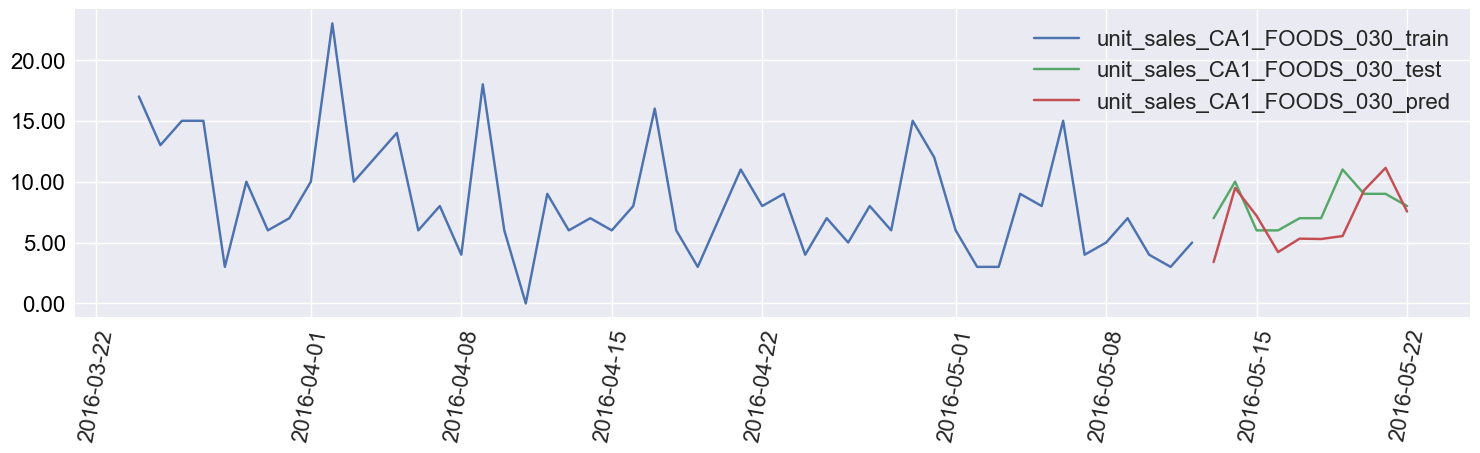

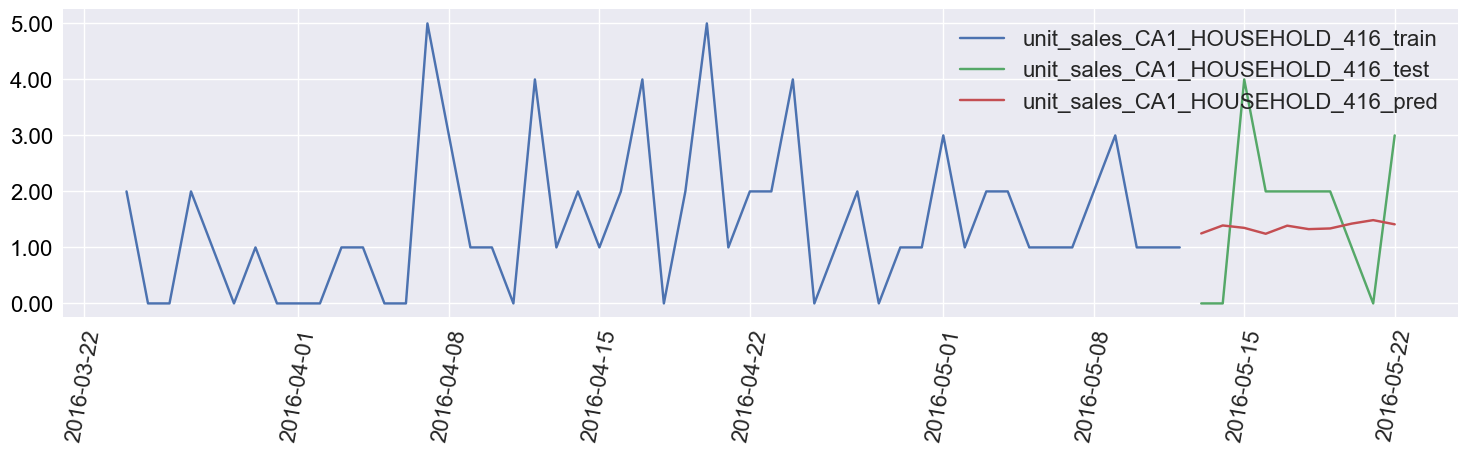

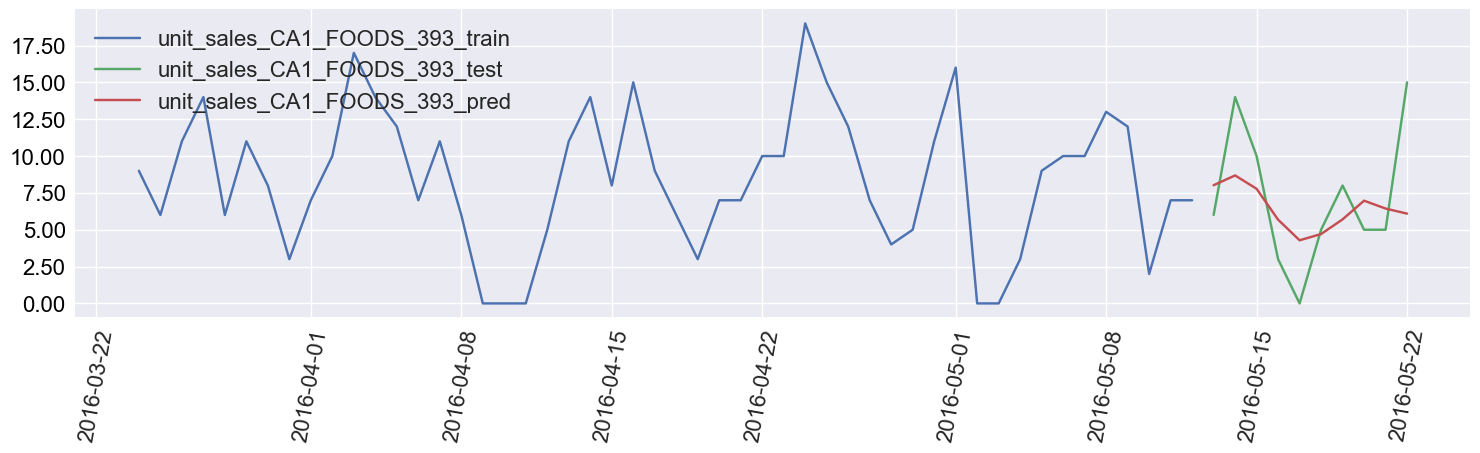

In [9]:

df = dfXYtf_pred.reset_index() # seaborn lineplot function needs x-axis to be a column

y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_HOUSEHOLD_416"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_FOODS_393"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)


predict - exogenous, categorical, endogenous

In [10]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sfmvembmo.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred


1/1 [==============================] - 0s 48ms/step


,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_FOODS_393_pred
2016-05-23,4.663242,1.274517,6.005696
2016-05-24,5.802432,1.391430,4.814401
2016-05-25,5.477890,1.341600,5.210756


## Train, Test and Validation

The purpose of this next exericise is for validation of our predictions against unseen data. The key goal is to validate that the sliding forecast (sforecast) 
out-of-sample predictions are the same as for predictions on unseen data. Below is the process for validating the out-of-sample predictions are correct.

We will use the multivariate, exogenous, endogenous, categorical case. 

Step 1. Create training/Test and validation (holdout set) data sets.   

Step 2.  Train Test with sforecast -  slidng forecast out of sample training and test, N-step recursive forecast methodFit the forecast model using the train/test data set

Step 3: Train (fit) using train set (separate from the validation set) ... 5 x 1-step recursive forward forecasts (should be identical to the above results)

Step 4. Compare the results of the two methods and ensure they produce equivalent results. Note, that thee will be some randomness in the predictions.


Before these steps - similar to all previous cases
* Setup dfXYtf data
* Derived variables Transform
* Exogenous variables ... previously setup with data import
* Define tensorflow model

In [4]:
# same data as previous multivariate example
dfXYtf = dfXY[covars+exogvars+le_catvars].copy()
all_columns = dfXYtf.columns
print("covars =",covars)
print("catvars =",catvars)
print("exogvars =",exogvars)
print(dfXYtf.shape)
display(dfXYtf.tail(10))

covars = ['unit_sales_CA1_HOUSEHOLD_416', 'unit_sales_CA1_FOODS_044', 'unit_sales_CA1_FOODS_030', 'unit_sales_CA1_HOBBIES_418', 'unit_sales_CA1_FOODS_185', 'unit_sales_CA1_HOUSEHOLD_219', 'unit_sales_CA1_FOODS_393']
catvars = ['weekday', 'event_name_1', 'event_name_2']
exogvars = ['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-13,0.0,2.0,7.0,2.0,1.0,0.0,6.0,2016,5,19,0,100.7612,5,30,3
2016-05-14,0.0,1.0,10.0,0.0,6.0,1.0,14.0,2016,5,19,0,100.7612,6,30,3
2016-05-15,4.0,1.0,6.0,0.0,3.0,1.0,10.0,2016,5,19,0,100.7612,0,30,3
2016-05-16,2.0,2.0,6.0,1.0,0.0,1.0,3.0,2016,5,20,0,100.7612,1,30,3
2016-05-17,2.0,4.0,7.0,1.0,1.0,0.0,0.0,2016,5,20,0,100.7612,2,30,3
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3


Edogenous (derived) variables, same as before

In [5]:
# deirvied variables transform

# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes_tf(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
        
        v1 = "unit_sales_CA1_FOODS_030"
        v2 = "unit_sales_CA1_FOODS_393"
        self.vlist = [v1, v2]
        f1 = lambda x:x+"_m1_ravg"+str(Nr)
        f2 = lambda x:x+"_m1_rstd"+str(Nr)
        self.new_attributes = [f(v) for f in (f1, f2 )for v in self.vlist]
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
                # variables
        
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        for v in self.vlist:
            v_ravg = v+"_m1_ravg"+str(Nr)
            v_rstd =  v+"_m1_rstd"+str(Nr)
            v_m1 = v+"_m1"
            dfnew[v_ravg] = dfnew[v_m1].rolling(window=Nr).mean()
            dfnew[v_rstd] = dfnew[v_m1].rolling(window=Nr).std()

        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows that should be desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return self.new_attributes
 
cols = ["unit_sales_CA1_FOODS_030" ,  "unit_sales_CA1_FOODS_393"]        
dfXY_m1 = dfXYtf[cols].copy()


# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes_tf().get_Nclip()
print("Nclip =",Nclip)
drived_var_transform = derived_attributes_tf()
dfXY_m1[["unit_sales_CA1_FOODS_030_m1" , "unit_sales_CA1_FOODS_393_m1" ]] = dfXY_m1[["unit_sales_CA1_FOODS_030" ,  "unit_sales_CA1_FOODS_393"]].shift(1)
dftest = drived_var_transform.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest.tail(5))

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

new_attributes = drived_var_transform.get_derived_attribute_names()
print(f'\nnew_attribute_names = {new_attributes}')

Nclip = 3
dataframe, dftest, with derived variables


,unit_sales_CA1_FOODS_030,unit_sales_CA1_FOODS_393,unit_sales_CA1_FOODS_030_m1,unit_sales_CA1_FOODS_393_m1,unit_sales_CA1_FOODS_030_m1_ravg3,unit_sales_CA1_FOODS_030_m1_rstd3,unit_sales_CA1_FOODS_393_m1_ravg3,unit_sales_CA1_FOODS_393_m1_rstd3
date,,,,,,,,
2016-05-18,7.0,5.0,7.0,0.0,6.333333,0.577350,4.333333,5.131601
2016-05-19,11.0,8.0,7.0,5.0,6.666667,0.577350,2.666667,2.516611
2016-05-20,9.0,5.0,11.0,8.0,8.333333,2.309401,4.333333,4.041452
2016-05-21,9.0,5.0,9.0,5.0,9.000000,2.000000,6.000000,1.732051
2016-05-22,8.0,15.0,9.0,5.0,9.666667,1.154701,6.000000,1.732051


Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


,unit_sales_CA1_FOODS_030,unit_sales_CA1_FOODS_393,unit_sales_CA1_FOODS_030_m1,unit_sales_CA1_FOODS_393_m1
date,,,,
2016-05-20,9.0,5.0,11.0,8.0
2016-05-21,9.0,5.0,9.0,5.0
2016-05-22,8.0,15.0,9.0,5.0



new_attribute_names = ['unit_sales_CA1_FOODS_030_m1_ravg3', 'unit_sales_CA1_FOODS_393_m1_ravg3', 'unit_sales_CA1_FOODS_030_m1_rstd3', 'unit_sales_CA1_FOODS_393_m1_rstd3']


Step 1. Create training/Test and validation (holdout set) data sets.  

In [6]:
dfXY_traintest = dfXYtf
dfXY_train = dfXYtf[:1199] # training set ... all but the last 7 rows
dfXY_valid = dfXYtf[1199:] # validation last 7 rows
dfXY_valid.columns = [c+"_valid" if "unit_sales_" in c else c for c in dfXY_valid.columns]
print("dfXY_train")
display(dfXY_train.tail())

print("dfXY_valid")
display(dfXY_valid)

dfXY_train


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-11,1.0,1.0,3.0,4.0,3.0,0.0,7.0,2016,5,19,0,100.7612,3,30,3
2016-05-12,1.0,0.0,5.0,1.0,0.0,0.0,7.0,2016,5,19,0,100.7612,4,30,3
2016-05-13,0.0,2.0,7.0,2.0,1.0,0.0,6.0,2016,5,19,0,100.7612,5,30,3
2016-05-14,0.0,1.0,10.0,0.0,6.0,1.0,14.0,2016,5,19,0,100.7612,6,30,3
2016-05-15,4.0,1.0,6.0,0.0,3.0,1.0,10.0,2016,5,19,0,100.7612,0,30,3


dfXY_valid


,unit_sales_CA1_HOUSEHOLD_416_valid,unit_sales_CA1_FOODS_044_valid,unit_sales_CA1_FOODS_030_valid,unit_sales_CA1_HOBBIES_418_valid,unit_sales_CA1_FOODS_185_valid,unit_sales_CA1_HOUSEHOLD_219_valid,unit_sales_CA1_FOODS_393_valid,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-16,2.0,2.0,6.0,1.0,0.0,1.0,3.0,2016,5,20,0,100.7612,1,30,3
2016-05-17,2.0,4.0,7.0,1.0,1.0,0.0,0.0,2016,5,20,0,100.7612,2,30,3
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3


**Step 2**

Train Test out-of-sample forecast over the the entire dataset with sforecast: N-step recursive forecast, 7 x 1-step recursive predictions


TF Model for Step 2 - multivariate, dense, Categorical Embeddings + multiple output

In [7]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Nendogvars = 4
Ndense = Nlags * Ncovars + Nexogvars + Nendogvars #lagged covars (does not include unlagged covars) + exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
print(f'Nout = {Nout}')

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
cont_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(cont_inputs)

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_dense_emb1 = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile ...
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb1.compile(loss='mse', optimizer=optimizer)

print(model_tf_dense_emb1.summary())

Ndense = 44
Nemb = 3
Nout = 7
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 44)]         0           []                               
                                                                

2023-01-13 07:22:02.113045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Step 2 fit predict

In [8]:
# sliding out of sample forecast
# display data
print("dfXY_traintest")
display(dfXY_traintest.tail(8))

y = ["unit_sales_CA1_FOODS_030",  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model

# forecast fit
Ntest = 7
Nhorizon = 7
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "catvars":le_catvars,
    "derived_attributes_transform": derived_attributes_tf
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sfmvembmo = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense_emb1, tf_parameters=tf_params)

df_pred = sfmvembmo.fit(dfXY_traintest)

df_pred_s2=df_pred[1199:][["unit_sales_CA1_FOODS_030_pred", "unit_sales_CA1_FOODS_393_pred"] ] # keep last 7 rows (i.e., 7 x 1-step recursive out-of-samppe)

df_pred_s2.columns = ["unit_sales_CA1_FOODS_030_pred_s2", "unit_sales_CA1_FOODS_393_pred_s2"] # change column names

df_pred_s2


dfXY_traintest


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-15,4.0,1.0,6.0,0.0,3.0,1.0,10.0,2016,5,19,0,100.7612,0,30,3
2016-05-16,2.0,2.0,6.0,1.0,0.0,1.0,3.0,2016,5,20,0,100.7612,1,30,3
2016-05-17,2.0,4.0,7.0,1.0,1.0,0.0,0.0,2016,5,20,0,100.7612,2,30,3
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3



y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 32ms/step


,unit_sales_CA1_FOODS_030_pred_s2,unit_sales_CA1_FOODS_393_pred_s2
date,,
2016-05-16,4.878854,6.514972
2016-05-17,5.206501,5.161479
2016-05-18,2.366761,5.331995
2016-05-19,2.499500,5.653150
2016-05-20,5.760969,6.440699
2016-05-21,5.201928,7.162325
2016-05-22,4.965774,6.701777


**Step 3** 

Train (fit) using train set (separate from the validation set) ... 7 x 1-step recursive forward forecasts (should be identical to the above results)


TF Model for Step 3 - multivariate, dense, Categorical Embeddings + multiple output

In [9]:
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Nendogvars = 4
Ndense = Nlags * Ncovars + Nexogvars + Nendogvars #lagged covars (does not include unlagged covars) + exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
print(f'Nout = {Nout}')

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
cont_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(cont_inputs)

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_dense_emb2 = Model(inputs=[cont_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile ...
optimizer = Adam(learning_rate=0.05, decay=.1)
model_tf_dense_emb2.compile(loss='mse', optimizer=optimizer)

print(model_tf_dense_emb2.summary())

Ndense = 44
Nemb = 3
Nout = 7
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 44)]         0           []                               
                                                              

fit and predict

In [10]:
# display data
print("dfXY_train")
display(dfXY_train.tail(5))

y = ["unit_sales_CA1_FOODS_030",  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will retrain/tune the existing model

# forecast fit
Ntest = 0
Nhorizon = 7
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "catvars":le_catvars,
    "derived_attributes_transform": derived_attributes_tf
    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sfmvembmo = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense_emb2, tf_parameters=tf_params)

sfmvembmo.fit(dfXY_train)

# Forecast Nperiods forward 7 x 1-step recursive predictions
dfexogs=dfXY_traintest[1199:][exogvars]
dfcats=dfXY_traintest[1199:][le_catvars]
ts_period = pd.DateOffset(days=1)
df_pred_s3=sfmvembmo.predict(Nperiods=7,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred_s3.columns = ["unit_sales_CA1_FOODS_030_pred_s3",	"unit_sales_CA1_FOODS_393_pred_s3"]
df_pred_s3


dfXY_train


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-11,1.0,1.0,3.0,4.0,3.0,0.0,7.0,2016,5,19,0,100.7612,3,30,3
2016-05-12,1.0,0.0,5.0,1.0,0.0,0.0,7.0,2016,5,19,0,100.7612,4,30,3
2016-05-13,0.0,2.0,7.0,2.0,1.0,0.0,6.0,2016,5,19,0,100.7612,5,30,3
2016-05-14,0.0,1.0,10.0,0.0,6.0,1.0,14.0,2016,5,19,0,100.7612,6,30,3
2016-05-15,4.0,1.0,6.0,0.0,3.0,1.0,10.0,2016,5,19,0,100.7612,0,30,3



y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 26ms/step


,unit_sales_CA1_FOODS_030_pred_s3,unit_sales_CA1_FOODS_393_pred_s3
2016-05-16,5.168309,6.103941
2016-05-17,5.041432,5.214328
2016-05-18,3.528246,5.335378
2016-05-19,4.658106,6.257293
2016-05-20,6.480623,6.600979
2016-05-21,7.551990,6.878679
2016-05-22,7.253484,6.332674


Step 4. Compare the results of the two methods

ensure they are stistically equivalent and that the test 2 sliding forecast method is not exhibiting leakage

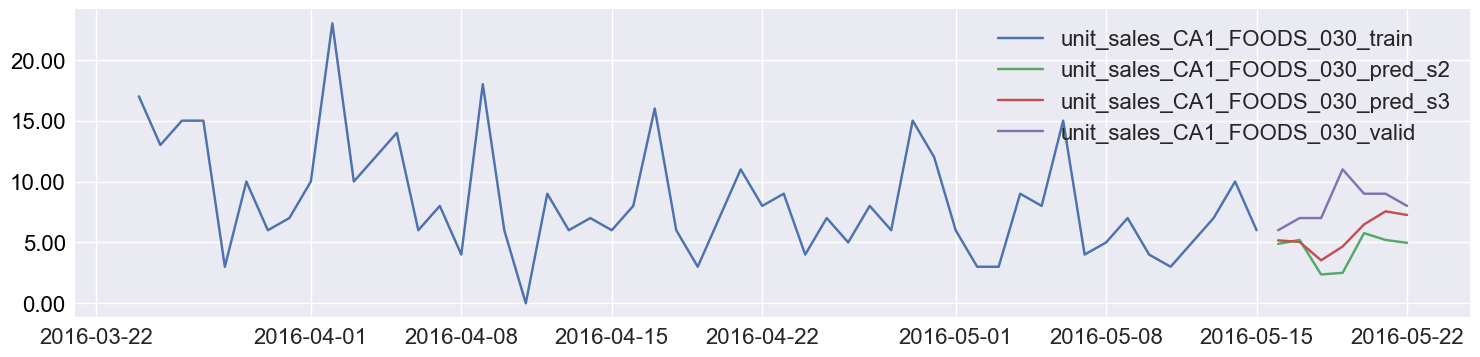

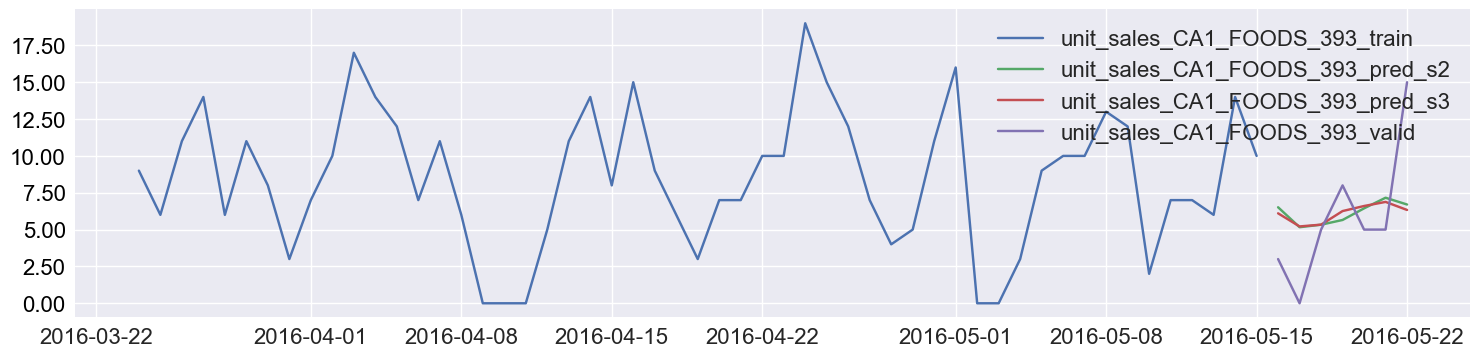

,unit_sales_CA1_FOODS_030_train,unit_sales_CA1_FOODS_393_train,unit_sales_CA1_FOODS_030_pred_s2,unit_sales_CA1_FOODS_393_pred_s2,unit_sales_CA1_FOODS_030_pred_s3,unit_sales_CA1_FOODS_393_pred_s3,unit_sales_CA1_FOODS_030_valid,unit_sales_CA1_FOODS_393_valid
date,,,,,,,,
2016-05-13,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-14,10.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-15,6.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-05-16,NaN,NaN,4.878854,6.514972,5.168309,6.103941,6.0,3.0
2016-05-17,NaN,NaN,5.206501,5.161479,5.041432,5.214328,7.0,0.0
2016-05-18,NaN,NaN,2.366761,5.331995,3.528246,5.335378,7.0,5.0
2016-05-19,NaN,NaN,2.499500,5.653150,4.658106,6.257293,11.0,8.0
2016-05-20,NaN,NaN,5.760969,6.440699,6.480623,6.600979,9.0,5.0
2016-05-21,NaN,NaN,5.201928,7.162325,7.551990,6.878679,9.0,5.0


In [11]:

# Join the training, predictions and validations for easy comparison 
dfXY_testtrainpred = pd.concat([dfXY_train[y], df_pred_s2])
dfXY_testtrainpred=dfXY_testtrainpred.rename({"unit_sales_CA1_FOODS_030":"unit_sales_CA1_FOODS_030_train","unit_sales_CA1_FOODS_393":"unit_sales_CA1_FOODS_393_train" }, axis=1)
dfXY_testtrainpred = dfXY_testtrainpred.join(df_pred_s3)
dfXY_testtrainpred = dfXY_testtrainpred.join(dfXY_valid[["unit_sales_CA1_FOODS_030_valid","unit_sales_CA1_FOODS_393_valid"]])


# plot
dfXY_plot = dfXY_testtrainpred.reset_index()

bp.lineplot(dfXY_plot.tail(60), x= "date", y=["unit_sales_CA1_FOODS_030_train", "unit_sales_CA1_FOODS_030_pred_s2", "unit_sales_CA1_FOODS_030_pred_s3","unit_sales_CA1_FOODS_030_valid"  ] , figsize=(18,4) , legend=True)

bp.lineplot(dfXY_plot.tail(60), x= "date", y=["unit_sales_CA1_FOODS_393_train", "unit_sales_CA1_FOODS_393_pred_s2", "unit_sales_CA1_FOODS_393_pred_s3","unit_sales_CA1_FOODS_393_valid"  ] , figsize=(18,4) , legend=True)


# display

display(dfXY_testtrainpred.tail(10))


## Multivariate Exen Groups

Data

In [4]:

# unit_sales_CA_1_FOODS_2_FOODS_2_044
# unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416
# unit_sales_CA_1_FOODS_3_FOODS_3_393
# y forecast variable
#y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030", "unit_sales_CA_1_HOUSEHOLD_1_HOUSEHOLD_1_416" ]

# endogenous variables = new attribute names (i.e., derived attributes)
endogs =  ['unit_sales_CA1_FOODS_030_m1_ravg3', 'unit_sales_CA1_HOUSEHOLD_416_m1_ravg3', 
           'unit_sales_CA1_FOODS_393_m1_ravg3', 'unit_sales_CA1_FOODS_030_m1_rstd3', 
           'unit_sales_CA1_HOUSEHOLD_416_m1_rstd3', 'unit_sales_CA1_FOODS_393_m1_rstd3']


exenvars = [ ['year', 'month', 'week', 'snap_CA'] +endogs, ['CCI_USA'] ] # envars list of lists. Each processed differently by the TF model
Nexenvars1 = len(exenvars[0])
Nexenvars2 = len(exenvars[1])
print(catvars)
print("exenvars =",exenvars)
print(f'Nexenvars1 = {Nexenvars1}')
print(f'Nexenvars2 = {Nexenvars2}')
dfXYtf= dfXY[covars+exogvars+le_catvars]
print("dfXYmvexcatso.shape =",dfXYtf.shape)
display(dfXYtf.head())

['weekday', 'event_name_1', 'event_name_2']
exenvars = [['year', 'month', 'week', 'snap_CA', 'unit_sales_CA1_FOODS_030_m1_ravg3', 'unit_sales_CA1_HOUSEHOLD_416_m1_ravg3', 'unit_sales_CA1_FOODS_393_m1_ravg3', 'unit_sales_CA1_FOODS_030_m1_rstd3', 'unit_sales_CA1_HOUSEHOLD_416_m1_rstd3', 'unit_sales_CA1_FOODS_393_m1_rstd3'], ['CCI_USA']]
Nexenvars1 = 10
Nexenvars2 = 1
dfXYmvexcatso.shape = (1206, 15)


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2013-02-02,2.0,0.0,43.0,0.0,0.0,0.0,4.0,2013,2,5,1,98.72734,6,30,3
2013-02-03,0.0,0.0,33.0,0.0,0.0,0.0,5.0,2013,2,5,1,98.72734,0,26,3
2013-02-04,1.0,1.0,5.0,0.0,0.0,0.0,1.0,2013,2,6,1,98.72734,1,30,3
2013-02-05,0.0,1.0,14.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,2,30,3
2013-02-06,0.0,1.0,11.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,3,30,3


derived attributes ... for convenience, repeated from previous multivariate case 

In [5]:
# deirvied variables transform

# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes_tf(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
        
        v1 = "unit_sales_CA1_FOODS_030"
        v2 = "unit_sales_CA1_HOUSEHOLD_416"
        v3 = "unit_sales_CA1_FOODS_393"
        self.vlist = [v1, v2, v3]
        f1 = lambda x:x+"_m1_ravg"+str(Nr)
        f2 = lambda x:x+"_m1_rstd"+str(Nr)
        self.new_attributes = [f(v) for f in (f1, f2 )for v in self.vlist]
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
                # variables
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        for v in self.vlist:
            v_ravg = v+"_m1_ravg"+str(Nr)
            v_rstd =  v+"_m1_rstd"+str(Nr)
            v_m1 = v+"_m1"
            dfnew[v_ravg] = dfnew[v_m1].rolling(window=Nr).mean()
            dfnew[v_rstd] = dfnew[v_m1].rolling(window=Nr).std()

        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows that should be desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return self.new_attributes
 
cols = ["unit_sales_CA1_FOODS_030" , "unit_sales_CA1_HOUSEHOLD_416" , "unit_sales_CA1_FOODS_393"]        
dfXY_m1 = dfXYtf[cols].copy()
# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes_tf().get_Nclip()
print("Nclip =",Nclip)
drived_var_transform = derived_attributes_tf()
dfXY_m1[["unit_sales_CA1_FOODS_030_m1" , "unit_sales_CA1_HOUSEHOLD_416_m1" , "unit_sales_CA1_FOODS_393_m1" ]] = dfXY_m1[["unit_sales_CA1_FOODS_030" , "unit_sales_CA1_HOUSEHOLD_416" , "unit_sales_CA1_FOODS_393"]].shift(1)
dftest = drived_var_transform.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest.tail(5))

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

new_attributes = drived_var_transform.get_derived_attribute_names()
print(f'\nnew_attribute_names = {new_attributes}')

Nclip = 3
dataframe, dftest, with derived variables


,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_393,unit_sales_CA1_FOODS_030_m1,unit_sales_CA1_HOUSEHOLD_416_m1,unit_sales_CA1_FOODS_393_m1,unit_sales_CA1_FOODS_030_m1_ravg3,unit_sales_CA1_FOODS_030_m1_rstd3,unit_sales_CA1_HOUSEHOLD_416_m1_ravg3,unit_sales_CA1_HOUSEHOLD_416_m1_rstd3,unit_sales_CA1_FOODS_393_m1_ravg3,unit_sales_CA1_FOODS_393_m1_rstd3
date,,,,,,,,,,,,
2016-05-18,7.0,2.0,5.0,7.0,2.0,0.0,6.333333,0.577350,2.666667,1.154701,4.333333,5.131601
2016-05-19,11.0,2.0,8.0,7.0,2.0,5.0,6.666667,0.577350,2.000000,0.000000,2.666667,2.516611
2016-05-20,9.0,1.0,5.0,11.0,2.0,8.0,8.333333,2.309401,2.000000,0.000000,4.333333,4.041452
2016-05-21,9.0,0.0,5.0,9.0,1.0,5.0,9.000000,2.000000,1.666667,0.577350,6.000000,1.732051
2016-05-22,8.0,3.0,15.0,9.0,0.0,5.0,9.666667,1.154701,1.000000,1.000000,6.000000,1.732051


Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_393,unit_sales_CA1_FOODS_030_m1,unit_sales_CA1_HOUSEHOLD_416_m1,unit_sales_CA1_FOODS_393_m1
date,,,,,,
2016-05-20,9.0,1.0,5.0,11.0,2.0,8.0
2016-05-21,9.0,0.0,5.0,9.0,1.0,5.0
2016-05-22,8.0,3.0,15.0,9.0,0.0,5.0



new_attribute_names = ['unit_sales_CA1_FOODS_030_m1_ravg3', 'unit_sales_CA1_HOUSEHOLD_416_m1_ravg3', 'unit_sales_CA1_FOODS_393_m1_ravg3', 'unit_sales_CA1_FOODS_030_m1_rstd3', 'unit_sales_CA1_HOUSEHOLD_416_m1_rstd3', 'unit_sales_CA1_FOODS_393_m1_rstd3']


TF Model: exogenous, endogenous, catvars ... CCI_USA processed a little differently sent directly to the output layer

In [6]:
###### 4 sets of inputs ... dense1 (covar lags), dense2 (exogs1), linear (exogs2), and embeddings (categorical inputs)
# linear exog directly to output
# TensorFlow model ... Categorical Embeddings + Dense (Continuous Variables), Multiple Ouput
Nlags = 5
Ndense1 = Nlags * Ncovars #lagged covars (does not include unlagged covars) + exogvars
Ndense2 = Nexenvars1
Nlinear = Nexenvars2
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print(f'Ndense1 = {Ndense1}')
print(f'Nemb = {Nemb}')
print(f'Ndense2 = {Ndense2}')
print(f'Nout = {Nout}')

# Dense input 1  ...  covar lags 
dense_inputs1 = Input((Ndense1,))
h1d = Dense(Ndense1, activation='relu')(dense_inputs1)

# Dense input 2 ...  exogs 1
dense_inputs2 = Input((Ndense2,))
h2d = Dense(Ndense2, activation='relu')(dense_inputs2)

# Input layer ... exogs2 linear input that will be passed directly to output
linear_inputs = Input((Nlinear))
hlinear = Dense(Nlinear, )(linear_inputs) # linear activation = None

# embeddings, cat vars
cat_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,cat_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined  ... combine lagged covars, embeddings, exogs1
combined = concatenate([h1d]+ emb_flat_list + [h2d])
combined_d = Dropout(0.2)(combined)

# dense reduction layers... Ndense1 lag variables + Ndense2 exogs1
Nh1c = Ndense1 + Ndense2 + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# combined to output ... combine the hidden reduced variables and the linear
comb_to_out = concatenate([h2c_d]+[hlinear])

# output
output = Dense(Nout)(comb_to_out)  # linear activation ... linear combination, activation = None 
model_tf_dense2_emb = Model(inputs=[dense_inputs1, dense_inputs2, linear_inputs, cat_inputs_list], outputs=output)

# define optimizer and compile
optimizer = Adam(learning_rate=0.07, decay=.2)
model_tf_dense2_emb.compile(loss='mse', optimizer=optimizer)

print(model_tf_dense2_emb.summary())

Ndense1 = 35
Nemb = 3
Ndense2 = 10
Nout = 7


2023-01-13 10:45:25.661729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 35)]         0           []                               
                                                                                              

TF fit forecast - exogenous, endogenous, categorical, exen groups

In [9]:

# display data
print("dfXYtf")
display(dfXYtf.tail(5))

y = ["unit_sales_CA1_FOODS_030", "unit_sales_CA1_HOUSEHOLD_416" ,  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model

# forecast fit
Ntest = 10
Nhorizon = 1
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":Nhorizon,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "exogvars":exogvars,
    "exenvars":exenvars,
    "catvars":le_catvars,
    "derived_attributes_transform": derived_attributes_tf

    }  

tf_params = {
    "Nepochs_i": 500,
    "Nepochs_t": 200,
    "batch_size":100  
}

sfmvembmo = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_dense2_emb, tf_parameters=tf_params)

df_pred = sfmvembmo.fit(dfXYtf)

print(f'\nmetrics = {sfmvembmo.metrics}')

dfXYtf_pred = dfXYtf.join(df_pred)

dfXYtf_pred

dfXYtf


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3



y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_HOUSEHOLD_416', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 91ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 3.1509957012534335, 'MAE': 2.4653923749923705}, 'unit_sales_CA1_HOUSEHOLD_416_pred': {'RMSE': 1.2826815758810843, 'MAE': 1.0764470100402832}, 'unit_sales_CA1_FOODS_393_pred': {'RMSE': 4.0242651120494655, 'MAE': 3.191401958465576}}


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,...,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_HOUSEHOLD_416_pred_error,unit_sales_CA1_HOUSEHOLD_416_pred_lower,unit_sales_CA1_HOUSEHOLD_416_pred_upper,unit_sales_CA1_FOODS_393_train,unit_sales_CA1_FOODS_393_test,unit_sales_CA1_FOODS_393_pred,unit_sales_CA1_FOODS_393_pred_error,unit_sales_CA1_FOODS_393_pred_lower,unit_sales_CA1_FOODS_393_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2013-02-02,2.0,0.0,43.0,0.0,0.0,0.0,4.0,2013,2,5,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
2013-02-03,0.0,0.0,33.0,0.0,0.0,0.0,5.0,2013,2,5,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
2013-02-04,1.0,1.0,5.0,0.0,0.0,0.0,1.0,2013,2,6,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2013-02-05,0.0,1.0,14.0,0.0,0.0,0.0,2.0,2013,2,6,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2013-02-06,0.0,1.0,11.0,0.0,0.0,0.0,2.0,2013,2,6,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,...,1.579245,-0.420755,0.000000,2.978096,NaN,5.0,4.380639,-0.619361,0.000000,7.447163
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,...,1.542027,-0.457973,0.000000,2.940878,NaN,8.0,4.877883,-3.122117,0.000000,7.944408
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,...,1.524530,0.524530,0.000000,2.923381,NaN,5.0,6.415610,1.415610,0.346249,9.482134


Plot

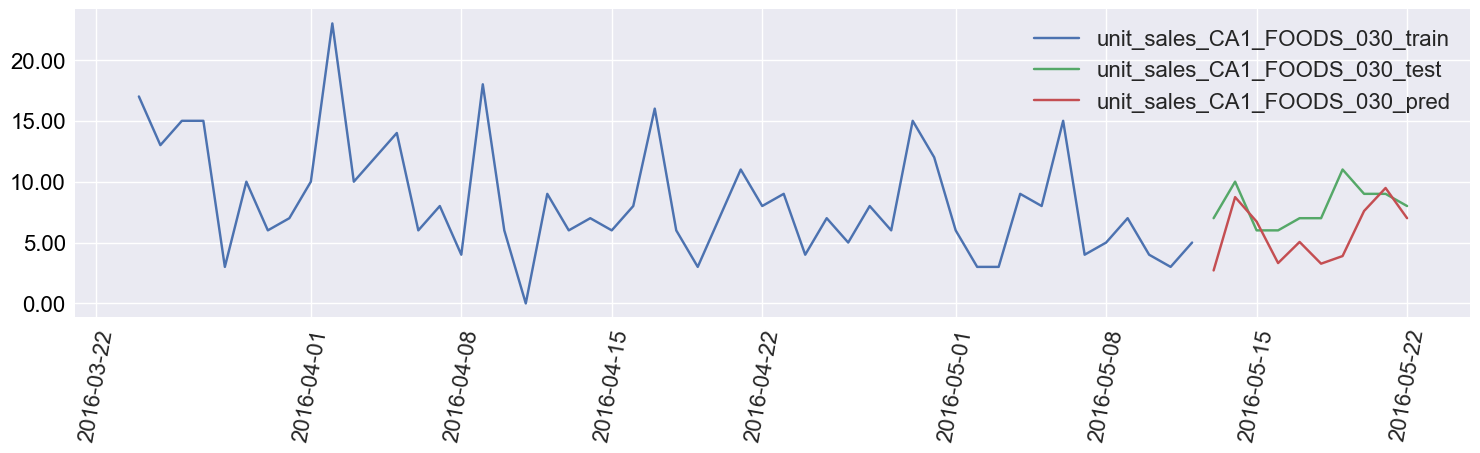

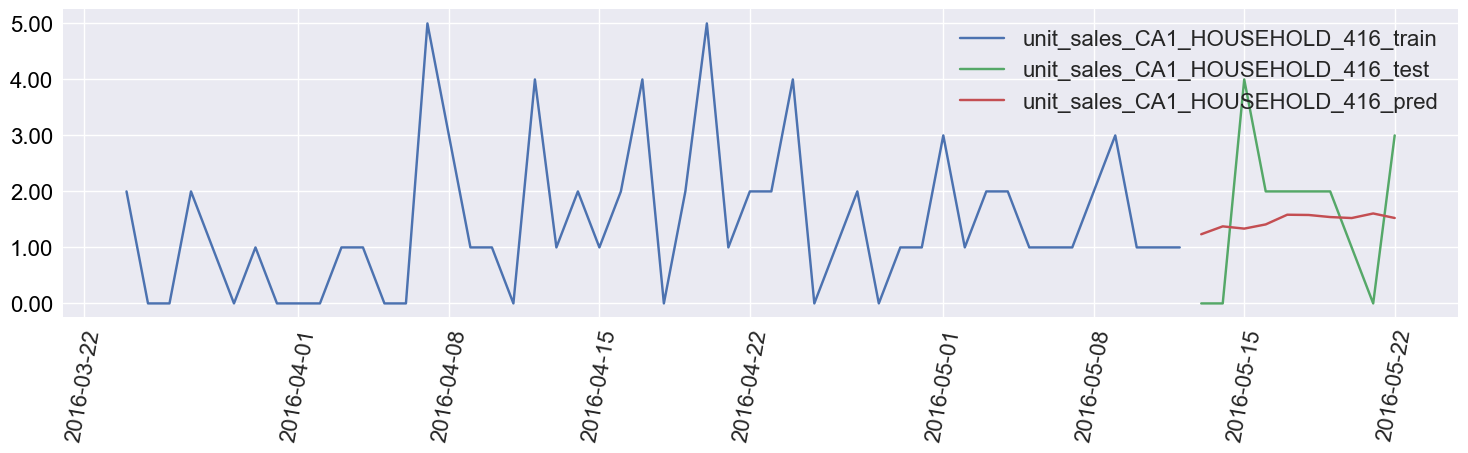

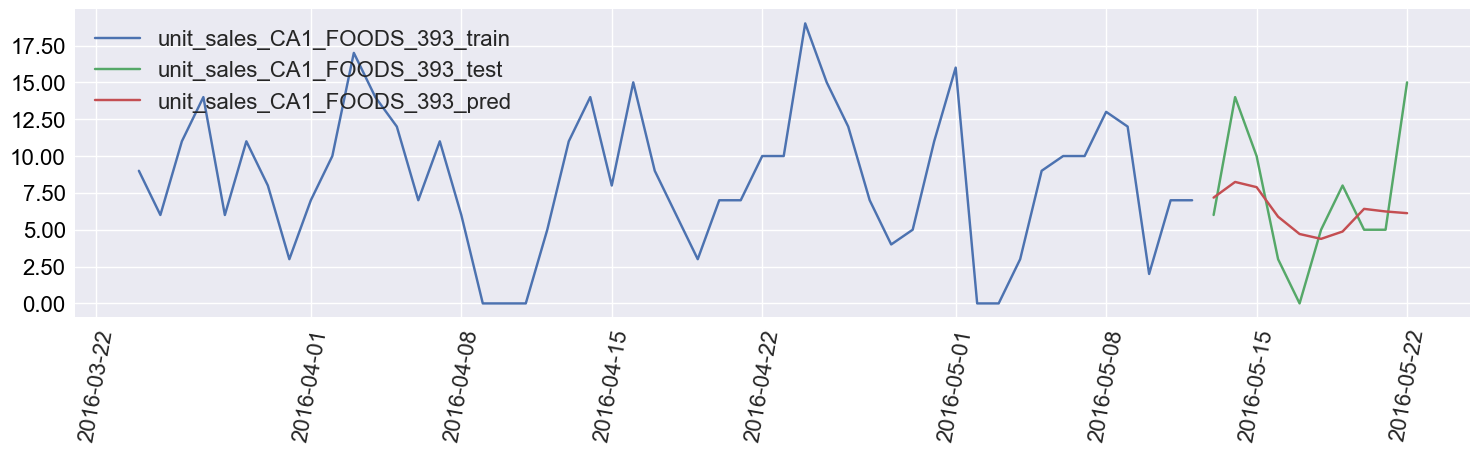

In [11]:
df = dfXYtf_pred.reset_index() # seaborn lineplot function needs x-axis to be a column

y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_HOUSEHOLD_416"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_FOODS_393"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

predict tf - multivariate, exogenous, endogenous, categorical, exen groups

In [12]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sfmvembmo.predict(Nperiods=5,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 29ms/step


,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_FOODS_393_pred
2016-05-23,3.853635,1.414470,6.404243
2016-05-24,4.821058,1.493593,5.659122
2016-05-25,3.947311,1.466771,5.755198
2016-05-26,1.984376,1.334086,6.211375
2016-05-27,2.752332,1.267644,7.067128


ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sfmvembmo.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

## LSTM Multivariate

Data

In [4]:
y = ["unit_sales_CA_1_FOODS_3_FOODS_3_030", "unit_sales_CA_1_FOODS_2_FOODS_2_044" ]

endogs =  ['unit_sales_CA1_FOODS_030_m1_ravg3', 'unit_sales_CA1_HOUSEHOLD_416_m1_ravg3', 
           'unit_sales_CA1_FOODS_393_m1_ravg3', 'unit_sales_CA1_FOODS_030_m1_rstd3', 
           'unit_sales_CA1_HOUSEHOLD_416_m1_rstd3', 'unit_sales_CA1_FOODS_393_m1_rstd3']

dfXYtf = dfXY[covars+exogvars+le_catvars]
print(catvars)
print(endogs)
print(exogvars)
print(dfXYtf.shape)
display(dfXYtf.head())

['weekday', 'event_name_1', 'event_name_2']
['unit_sales_CA1_FOODS_030_m1_ravg3', 'unit_sales_CA1_HOUSEHOLD_416_m1_ravg3', 'unit_sales_CA1_FOODS_393_m1_ravg3', 'unit_sales_CA1_FOODS_030_m1_rstd3', 'unit_sales_CA1_HOUSEHOLD_416_m1_rstd3', 'unit_sales_CA1_FOODS_393_m1_rstd3']
['year', 'month', 'week', 'snap_CA', 'CCI_USA']
(1206, 15)


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2013-02-02,2.0,0.0,43.0,0.0,0.0,0.0,4.0,2013,2,5,1,98.72734,6,30,3
2013-02-03,0.0,0.0,33.0,0.0,0.0,0.0,5.0,2013,2,5,1,98.72734,0,26,3
2013-02-04,1.0,1.0,5.0,0.0,0.0,0.0,1.0,2013,2,6,1,98.72734,1,30,3
2013-02-05,0.0,1.0,14.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,2,30,3
2013-02-06,0.0,1.0,11.0,0.0,0.0,0.0,2.0,2013,2,6,1,98.72734,3,30,3


Endogenous derived variables, repeated here for convenience

In [5]:
# deirvied variables transform

# derived attributes custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

# pipeline/transformer development
# BaseEstimater ... get_params(), set_params() methods
# TransformerMixin ... fit_transform() method
Nr = 3
class derived_attributes_tf(BaseEstimator,TransformerMixin):
    def __init__(self, Nr = Nr): 
        self.Nr = Nr # slidig/rolling window rows
        self.dfmemory = None
        
        v1 = "unit_sales_CA1_FOODS_030"
        v2 = "unit_sales_CA1_HOUSEHOLD_416"
        v3 = "unit_sales_CA1_FOODS_393"
        self.vlist = [v1, v2, v3]
        f1 = lambda x:x+"_m1_ravg"+str(Nr)
        f2 = lambda x:x+"_m1_rstd"+str(Nr)
        self.new_attributes = [f(v) for f in (f1, f2 )for v in self.vlist]
    
    def fit(self,df):
        # ensure dataframe has enough rows
        self.dfmemory = df.tail(self.Nr) if df.index.size > self.Nr else df.index.size
                # variables
        
        return self
    
    def transform(self,df=None, Nout=None, dfnewrows=None):
        # if df not spefified then transform on dfmemory
        # add new row(s) ... these will be provided from the predict operation
        if not isinstance(df,pd.DataFrame):
            df = self.dfmemory
            if isinstance(dfnewrows,pd.DataFrame):
                df = pd.concat([df,dfnewrows])
        self.dfmemory = df.tail(self.Nr) 
        Nr=self.Nr
        dfnew=df.copy()
        
        for v in self.vlist:
            v_ravg = v+"_m1_ravg"+str(Nr)
            v_rstd =  v+"_m1_rstd"+str(Nr)
            v_m1 = v+"_m1"
            dfnew[v_ravg] = dfnew[v_m1].rolling(window=Nr).mean()
            dfnew[v_rstd] = dfnew[v_m1].rolling(window=Nr).std()

        Nclip = self.Nr
        return dfnew if Nout == None else dfnew.tail(Nout)
    
    def get_Nclip(self): # returns the number of initial rows that should be desgarded (clipped) for NaN avoidence
        return self.Nr
    
    def get_derived_attribute_names(self):
        Nr = self.Nr
        return self.new_attributes
 
cols = ["unit_sales_CA1_FOODS_030" , "unit_sales_CA1_HOUSEHOLD_416" , "unit_sales_CA1_FOODS_393"]        
dfXY_m1 = dfXYtf[cols].copy()


# the variables eill be created by sforecast
# here we test the transform to see what the new variables look like.
Nclip =derived_attributes_tf().get_Nclip()
print("Nclip =",Nclip)
drived_var_transform = derived_attributes_tf()
dfXY_m1[["unit_sales_CA1_FOODS_030_m1" , "unit_sales_CA1_HOUSEHOLD_416_m1" , "unit_sales_CA1_FOODS_393_m1" ]] = dfXY_m1[["unit_sales_CA1_FOODS_030" , "unit_sales_CA1_HOUSEHOLD_416" , "unit_sales_CA1_FOODS_393"]].shift(1)
dftest = drived_var_transform.fit_transform(dfXY_m1)
print("dataframe, dftest, with derived variables")
display(dftest.tail(5))

print(f'Nr= {Nr} dfmemory 3 rows from dataframe, saved by the transform after first use')
display(drived_var_transform.dfmemory)

new_attributes = drived_var_transform.get_derived_attribute_names()
print(f'\nnew_attribute_names = {new_attributes}')

Nclip = 3
dataframe, dftest, with derived variables


,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_393,unit_sales_CA1_FOODS_030_m1,unit_sales_CA1_HOUSEHOLD_416_m1,unit_sales_CA1_FOODS_393_m1,unit_sales_CA1_FOODS_030_m1_ravg3,unit_sales_CA1_FOODS_030_m1_rstd3,unit_sales_CA1_HOUSEHOLD_416_m1_ravg3,unit_sales_CA1_HOUSEHOLD_416_m1_rstd3,unit_sales_CA1_FOODS_393_m1_ravg3,unit_sales_CA1_FOODS_393_m1_rstd3
date,,,,,,,,,,,,
2016-05-18,7.0,2.0,5.0,7.0,2.0,0.0,6.333333,0.577350,2.666667,1.154701,4.333333,5.131601
2016-05-19,11.0,2.0,8.0,7.0,2.0,5.0,6.666667,0.577350,2.000000,0.000000,2.666667,2.516611
2016-05-20,9.0,1.0,5.0,11.0,2.0,8.0,8.333333,2.309401,2.000000,0.000000,4.333333,4.041452
2016-05-21,9.0,0.0,5.0,9.0,1.0,5.0,9.000000,2.000000,1.666667,0.577350,6.000000,1.732051
2016-05-22,8.0,3.0,15.0,9.0,0.0,5.0,9.666667,1.154701,1.000000,1.000000,6.000000,1.732051


Nr= 3 dfmemory 3 rows from dataframe, saved by the transform after first use


,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_393,unit_sales_CA1_FOODS_030_m1,unit_sales_CA1_HOUSEHOLD_416_m1,unit_sales_CA1_FOODS_393_m1
date,,,,,,
2016-05-20,9.0,1.0,5.0,11.0,2.0,8.0
2016-05-21,9.0,0.0,5.0,9.0,1.0,5.0
2016-05-22,8.0,3.0,15.0,9.0,0.0,5.0



new_attribute_names = ['unit_sales_CA1_FOODS_030_m1_ravg3', 'unit_sales_CA1_HOUSEHOLD_416_m1_ravg3', 'unit_sales_CA1_FOODS_393_m1_ravg3', 'unit_sales_CA1_FOODS_030_m1_rstd3', 'unit_sales_CA1_HOUSEHOLD_416_m1_rstd3', 'unit_sales_CA1_FOODS_393_m1_rstd3']


LSTM (covariate lags) + Dense (exogenous vars) + Embeddings (categorical vars)

In [6]:
# TensorFlow model ... LSTM (covar lags) Embeddings (categorical) + Dense (exog vars), Multiple Ouput
Nlags = 5
Nlstmsteps = Nlags   #lagged covars (does not include unlagged covars)
Nlstmfeatures = Ncovars
Nexogs = len(exogvars)
Nendogs = len(endogs)
Ndense = Nexogs + Nendogs # exogvars
Nemb = Ncatvars
Nembout = sum(eoutdim)
Nout = len(covars)

print("Nlstmsteps =",Nlstmsteps)
print("Nlstmfeatures =",Ncovars)
print(f'Ndense = {Ndense}')
print(f'Nemb = {Nemb}')
print(f'Nout = {Nout}')

lstm_inputs = Input((Nlstmsteps,Nlstmfeatures))   # number of inputs = Nlags , number of features = Ncovars
h1lstm= LSTM(Nlstmsteps, activation='relu', input_shape = (Nlstmsteps, Nlstmfeatures))(lstm_inputs) # nsteps = Nlags

# Dense Network, 2 hidden layers, continuous variables ... covar lags and exogenous variables
dense_inputs = Input((Ndense,))
h1d = Dense(Ndense, activation='relu')(dense_inputs)

# embeddings, cat vars
emb_inputs_list = [ Input((1,)) for c in range(Nemb) ]  # one embedding for each categorical variable
emb_out_list = [Embedding(ein,eout,input_length=1)(cat) for ein,eout,cat in zip(eindim ,eoutdim,emb_inputs_list) ]
emb_flat_list = [Flatten()(emb_out) for emb_out in emb_out_list ]

# combined 
combined = concatenate([h1lstm] +[h1d]+emb_flat_list)
combined_d = Dropout(0.2)(combined)

# dense reduction layers
Nh1c = Nlstmsteps*Nlstmfeatures + Ndense + Nembout # 
h1c = Dense(Nh1c, activation='relu')(combined_d)
h1c_d = Dropout(0.2)(h1c)
Nh2c = np.rint(Nh1c/2).astype(int)
h2c = Dense(Nh2c, activation='relu')(h1c_d)
h2c_d = Dropout(0.2)(h2c)

# output
output = Dense(Nout)(h2c_d)  # linear activation ... linear combination 
model_tf_lstm = Model(inputs=[lstm_inputs, dense_inputs, emb_inputs_list], outputs=output)

# define optimizer and compile ..
optimizer = Adam(learning_rate=0.07, decay=.2)
model_tf_lstm.compile(loss='mse', optimizer=optimizer)

print(model_tf_lstm.summary())

Nlstmsteps = 5
Nlstmfeatures = 7
Ndense = 11
Nemb = 3
Nout = 7


2023-01-13 11:46:01.226122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                              

In [7]:

# display data
print("dfXYtf")
display(dfXYtf.tail(5))

y = ["unit_sales_CA1_FOODS_030", "unit_sales_CA1_HOUSEHOLD_416" ,  "unit_sales_CA1_FOODS_393" ]
print(f'\ny = {y}\n')

# Model Initialization - WARNING
# ... recreate and compile the model ... reruning this cell will tune the existing model

Ntest = 10
swin_params = {
    "Ntest":Ntest,
    "Nhorizon":1,
    "Nlags":Nlags,
    "minmax" :(0,None),
    "covars":covars,
    "catvars":le_catvars,
    "exogvars":exogvars,
    "derived_attributes_transform":derived_attributes_tf
    }  

tf_params = {
    "Nepochs_i": 1000,
    "Nepochs_t": 400,
    "batch_size":100,
    "lstm": True
}

sflstm = sf.sforecast(y = y, model_type="tf", swin_parameters=swin_params,model=model_tf_lstm, tf_parameters=tf_params)

df_pred =sflstm.fit(dfXYtf)

print(f'\nmetrics = {sflstm.metrics}')
dfXYtf_pred = dfXYtf.join(df_pred)
display(dfXYtf_pred.tail())

dfXYtf


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,snap_CA,CCI_USA,le_weekday,le_event_name_1,le_event_name_2
date,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,0,100.7612,3,30,3
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,0,100.7612,4,30,3
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,0,100.7612,5,30,3
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,0,100.7612,6,30,3
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,0,100.7612,0,30,3



y = ['unit_sales_CA1_FOODS_030', 'unit_sales_CA1_HOUSEHOLD_416', 'unit_sales_CA1_FOODS_393']

1/1 [==============================] - 0s 39ms/step

metrics = {'unit_sales_CA1_FOODS_030_pred': {'RMSE': 3.5122502979415304, 'MAE': 2.7507920980453493}, 'unit_sales_CA1_HOUSEHOLD_416_pred': {'RMSE': 1.3158590996865087, 'MAE': 1.1440175890922546}, 'unit_sales_CA1_FOODS_393_pred': {'RMSE': 4.262527341765812, 'MAE': 3.3451545238494873}}


,unit_sales_CA1_HOUSEHOLD_416,unit_sales_CA1_FOODS_044,unit_sales_CA1_FOODS_030,unit_sales_CA1_HOBBIES_418,unit_sales_CA1_FOODS_185,unit_sales_CA1_HOUSEHOLD_219,unit_sales_CA1_FOODS_393,year,month,week,...,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_HOUSEHOLD_416_pred_error,unit_sales_CA1_HOUSEHOLD_416_pred_lower,unit_sales_CA1_HOUSEHOLD_416_pred_upper,unit_sales_CA1_FOODS_393_train,unit_sales_CA1_FOODS_393_test,unit_sales_CA1_FOODS_393_pred,unit_sales_CA1_FOODS_393_pred_error,unit_sales_CA1_FOODS_393_pred_lower,unit_sales_CA1_FOODS_393_pred_upper
date,,,,,,,,,,,,,,,,,,,,,
2016-05-18,2.0,0.0,7.0,1.0,4.0,0.0,5.0,2016,5,20,...,1.295193,-0.704807,0.0,2.614368,NaN,5.0,4.120459,-0.879541,0.000000,7.585146
2016-05-19,2.0,0.0,11.0,1.0,1.0,0.0,8.0,2016,5,20,...,1.308883,-0.691117,0.0,2.628058,NaN,8.0,4.107284,-3.892716,0.000000,7.571971
2016-05-20,1.0,0.0,9.0,4.0,1.0,0.0,5.0,2016,5,20,...,1.324849,0.324849,0.0,2.644024,NaN,5.0,5.811911,0.811911,0.000000,9.276598
2016-05-21,0.0,3.0,9.0,0.0,2.0,2.0,5.0,2016,5,20,...,1.379954,1.379954,0.0,2.699129,NaN,5.0,6.731566,1.731566,0.137844,10.196253
2016-05-22,3.0,2.0,8.0,0.0,2.0,1.0,15.0,2016,5,20,...,1.367878,-1.632122,0.0,2.687053,NaN,15.0,6.253339,-8.746661,0.000000,9.718026


Plot

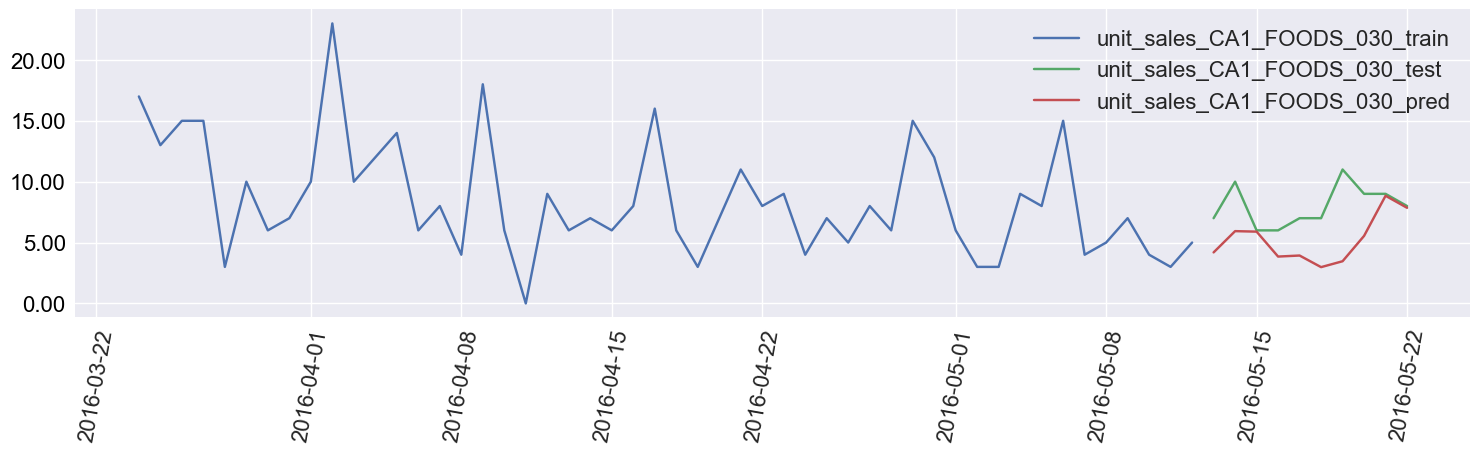

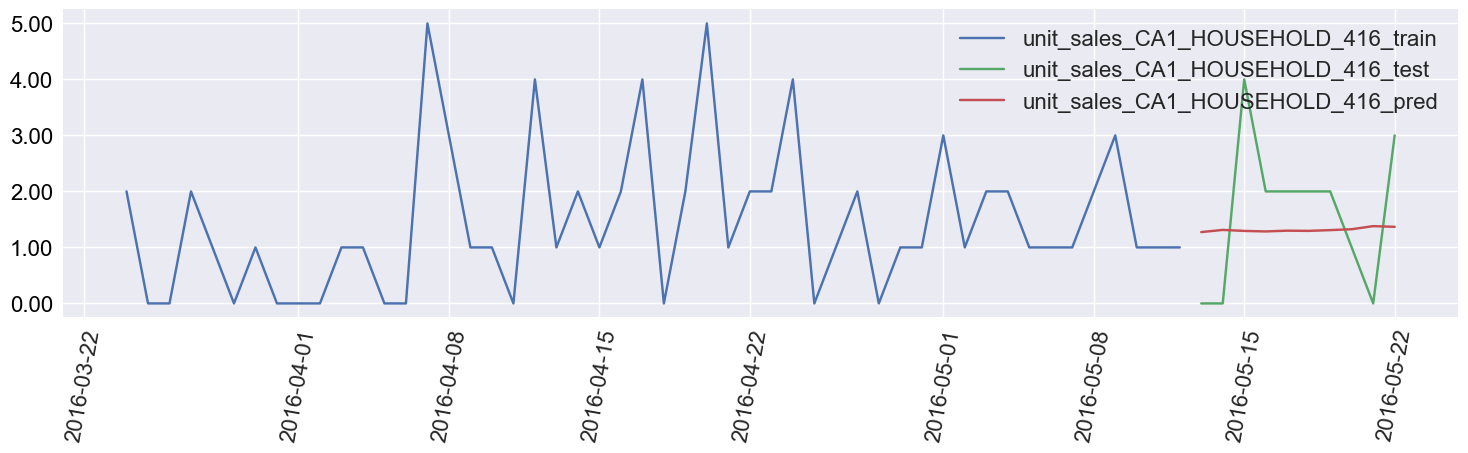

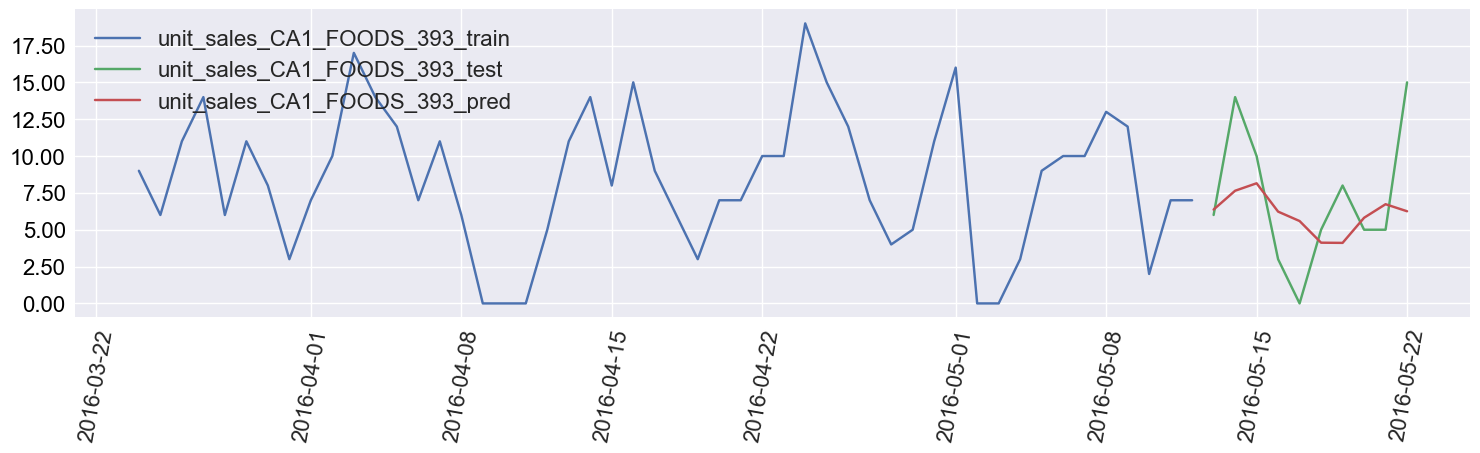

In [8]:
df = dfXYtf_pred.reset_index() # seaborn lineplot function needs x-axis to be a column

y = "unit_sales_CA1_FOODS_030"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_HOUSEHOLD_416"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

y = "unit_sales_CA1_FOODS_393"
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"

bp.lineplot(df.tail(60), x="date", y=[ytrain, ytest,ypred], figsize=(18,4),  x_tick_rotation=80)

predict  lstm, multivariate, exogvars, endogvars, categorical 

In [9]:
ts_period = pd.DateOffset(days=1)
dfexogs=pd.DataFrame(data = {"year":5*[2016],
                             "month": 5*[5],
                             "week": 5*[21],
                             "snap_CA": 5*[0],
                             "CCI_USA":5*[100.7612]
                             })

dfcats=pd.DataFrame(data = {"le_weekday":[1,2,3,4,5], "le_event_name_1": 5*[30], "le_event_name_2": 5 *[3]})
df_pred=sflstm.predict(Nperiods=3,dfexogs = dfexogs, dfcats = dfcats, ts_period=ts_period)
df_pred

1/1 [==============================] - 0s 34ms/step


,unit_sales_CA1_FOODS_030_pred,unit_sales_CA1_HOUSEHOLD_416_pred,unit_sales_CA1_FOODS_393_pred
2016-05-23,5.030982,1.330741,5.245764
2016-05-24,4.869828,1.330000,5.223783
2016-05-25,3.949784,1.307097,5.303581
